# Experiment 1.1 Shaping accuracy

Parameters:
- Sessions: {1, 2, 4, ..., 4096}
- Flows p Session: 2
- TOS per flow: {0 (HP), 1 (LP)}
- Packet sizes: {64, 256, 512, 1500}

In [1]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mat
import os
import seaborn as sns
import numpy as np
import matplotlib.ticker as mticker
import ast
import json
from sklearn import preprocessing

In [7]:
%config IPCompleter.greedy=True
%matplotlib notebook
%matplotlib inline
plt.rcParams["figure.figsize"] = [15, 10]

POINT_PLOT_DODGE = 0.15
sns.set(font_scale=2, style = 'white')

In [17]:
experiment_labels = [
        "1gbpsl1-2200",
        "2gbpsl1-2200",
        "3gbpsl1-2200",
        "4gbpsl1-2200",
        "5gbpsl1-2200",
        "6gbpsl1-2200",
        #"8192-6gbpsl1",
              ]
               
measurements = list()

for experiment in experiment_labels:
    output_dir = f"../output/vpp-flow-{experiment}"
    for direc, sub_direc, files in os.walk(output_dir):

        if 'discarded' in direc:
            continue

        if files == []:
            continue

        if 'old' in direc:
            continue

        t = dict()
        misses = 0
        drops = 0
        vectors = 0
        call = 0

        for file in files:

            none, flows, packet_size, repeat = direc.replace(output_dir, '').split('/')

            if 'vpp' in file:
                with open(direc + '/' + file, "r", encoding="utf8", errors='ignore') as f:
                    for line in f.readlines():
                        p = line.strip().split()
                        if '/interfaces/dev0/rx-miss' in p[-1] and '0' in p[2] and '0' in p[0]:
                            misses = int(p[3])

                        if '/err/dev1-tx/Tx' in p and '2]:' in p[2] and '[0' in p[0]:
                            drops = int(p[3])

                        if '/nodes/dev1-output/vectors' in p and '2]:' in p[2] and '[0' in p[0]:
                            vectors = int(p[3])

                        if '/nodes/dev1-output/calls' in p and '2]:' in p[2] and '[0' in p[0]:
                            calls = int(p[3])

            if 'trex' in file:
                with open(direc + '/' + file, "r") as f:
                    contents = f.read().replace("\n", "").replace("\'", "\"")
                    try:
                        t = ast.literal_eval(contents)
                    except SyntaxError:
                        print(direc + '/' + files[0])
                        continue              

        pkt_loss = t['total']['opackets']  - t['total']['ipackets']
        measurements.append(
        {
            'total_rx_L1': t['total']['rx_bps_L1'],
            'total_tx_L1': int(t['total']['tx_bps_L1']),
            'total_tx_pps': int(t['total']['tx_pps']),
            'total_rx_pps': int(t['total']['rx_pps']),
            'lost_packets': pkt_loss,
            'tx_util': t['total']['tx_util'],
            'flows': int(flows),
            'packet_size': int(packet_size),
            'misses': misses,
            'drops': drops,
            'misses_normalized': misses/(1 if pkt_loss == 0 else pkt_loss),
            'drops_normalized': drops/(1 if pkt_loss == 0 else pkt_loss),
            'units': repeat,
            'vectors': vectors,
            'call': calls,
            'Offered load': experiment.replace('-2200', ''),
            'experiment_int': int(experiment.replace('gbpsl1-2200', '')),
        })

    measurements_df = pd.DataFrame(measurements)

In [5]:
t_df = measurements_df
columns = ['misses', 'drops', 'units']
#columns = ['misses_normalized', 'drops_normalized']
error_df = pd.melt(t_df, id_vars = ['units', 'experiment_int', 'packet_size', 'flows', 'tx_util', 'lost_packets', 'Offered load'], value_vars = columns).rename(columns = {'variable': 'Error Type', 'value': 'Errors'})

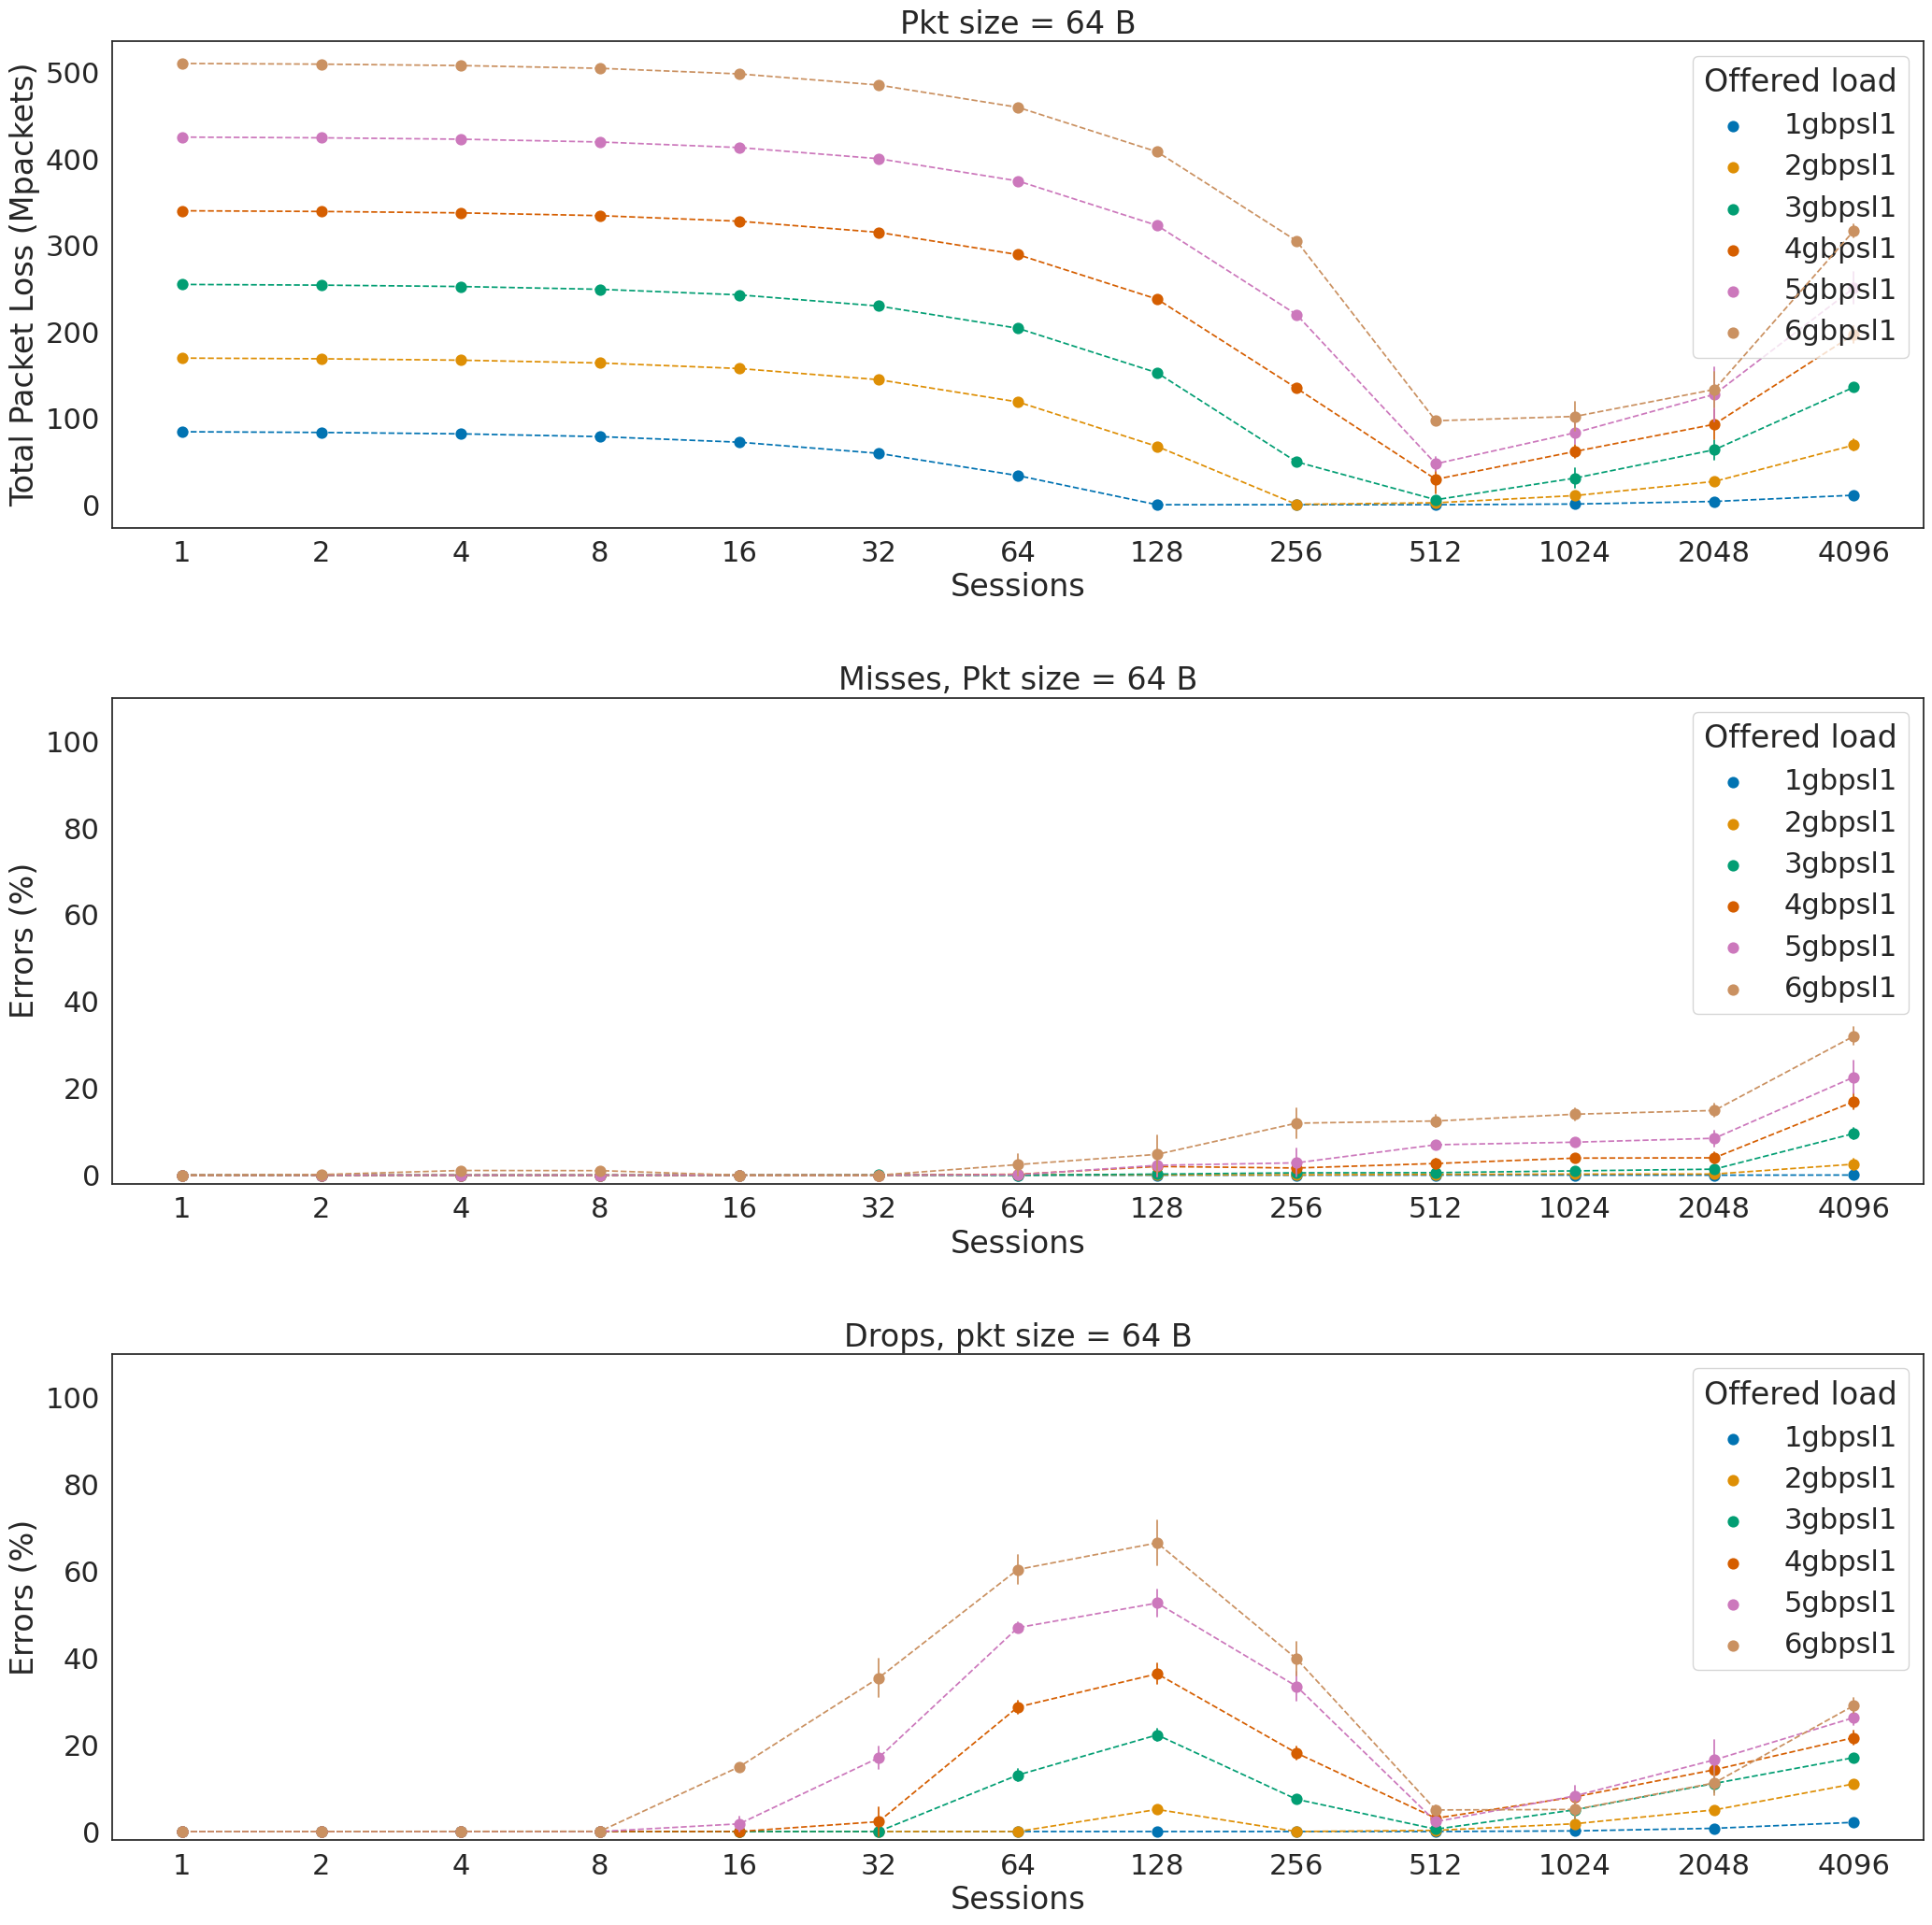

In [6]:
%matplotlib inline
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(25,25))

fig = sns.pointplot(
    data = measurements_df[measurements_df['packet_size'] == 64],
    x = 'flows',
    y = measurements_df['lost_packets']/(10**6),
    hue = 'Offered load',
    units = 'units',
    ax = ax1,
    palette = 'colorblind',
    ci = 'sd',
    err_style = 'bars',
    markersize=1,
    errorwidth=3,
    join = True,
    linestyles = '--',
    linewidth = 0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax1.set(
    ylabel = 'Total Packet Loss (Mpackets)',
    xlabel = 'Sessions',
    title = 'Pkt size = 64 B',
)
plt.setp(fig.lines,linewidth=1.25)

p_df = error_df[error_df['packet_size'] == 64]
fig = sns.pointplot(
    data = p_df[p_df['Error Type'] == 'misses'],
    x = 'flows',
    y = error_df['Errors']/max(error_df['lost_packets'])*100,
    hue = 'Offered load',
    units = 'units',
    ax = ax2,
    palette = 'colorblind',
    ci = 'sd',
    err_style = 'bars',
    markersize=1,
    errorwidth=3,
    join = True,
    linestyles = '--',
    linewidth = 0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax2.set(
    ylabel = 'Errors (%)',
    xlabel = 'Sessions',
    title = 'Misses, Pkt size = 64 B',
    ylim = [-2, 110],
)
plt.setp(fig.lines,linewidth=1.25)


p_df = error_df[error_df['packet_size'] == 64]
fig = sns.pointplot(
    data = p_df[p_df['Error Type'] == 'drops'],
    x = 'flows',
    y = error_df['Errors']/max(error_df['lost_packets'])*100,
    hue = 'Offered load',
    units = 'units',
    ax = ax3,
    palette = 'colorblind',
    ci = 'sd',
    err_style = 'bars',
    markersize=1,
    errorwidth=3,
    join = True,
    linestyles = '--',
    linewidth = 0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax3.set(
    ylabel = 'Errors (%)',
    xlabel = 'Sessions',
    title = 'Drops, pkt size = 64 B',
    ylim = [-2, 110],
)
plt.setp(fig.lines,linewidth=1.25)

plt.subplots_adjust(hspace = 0.35)


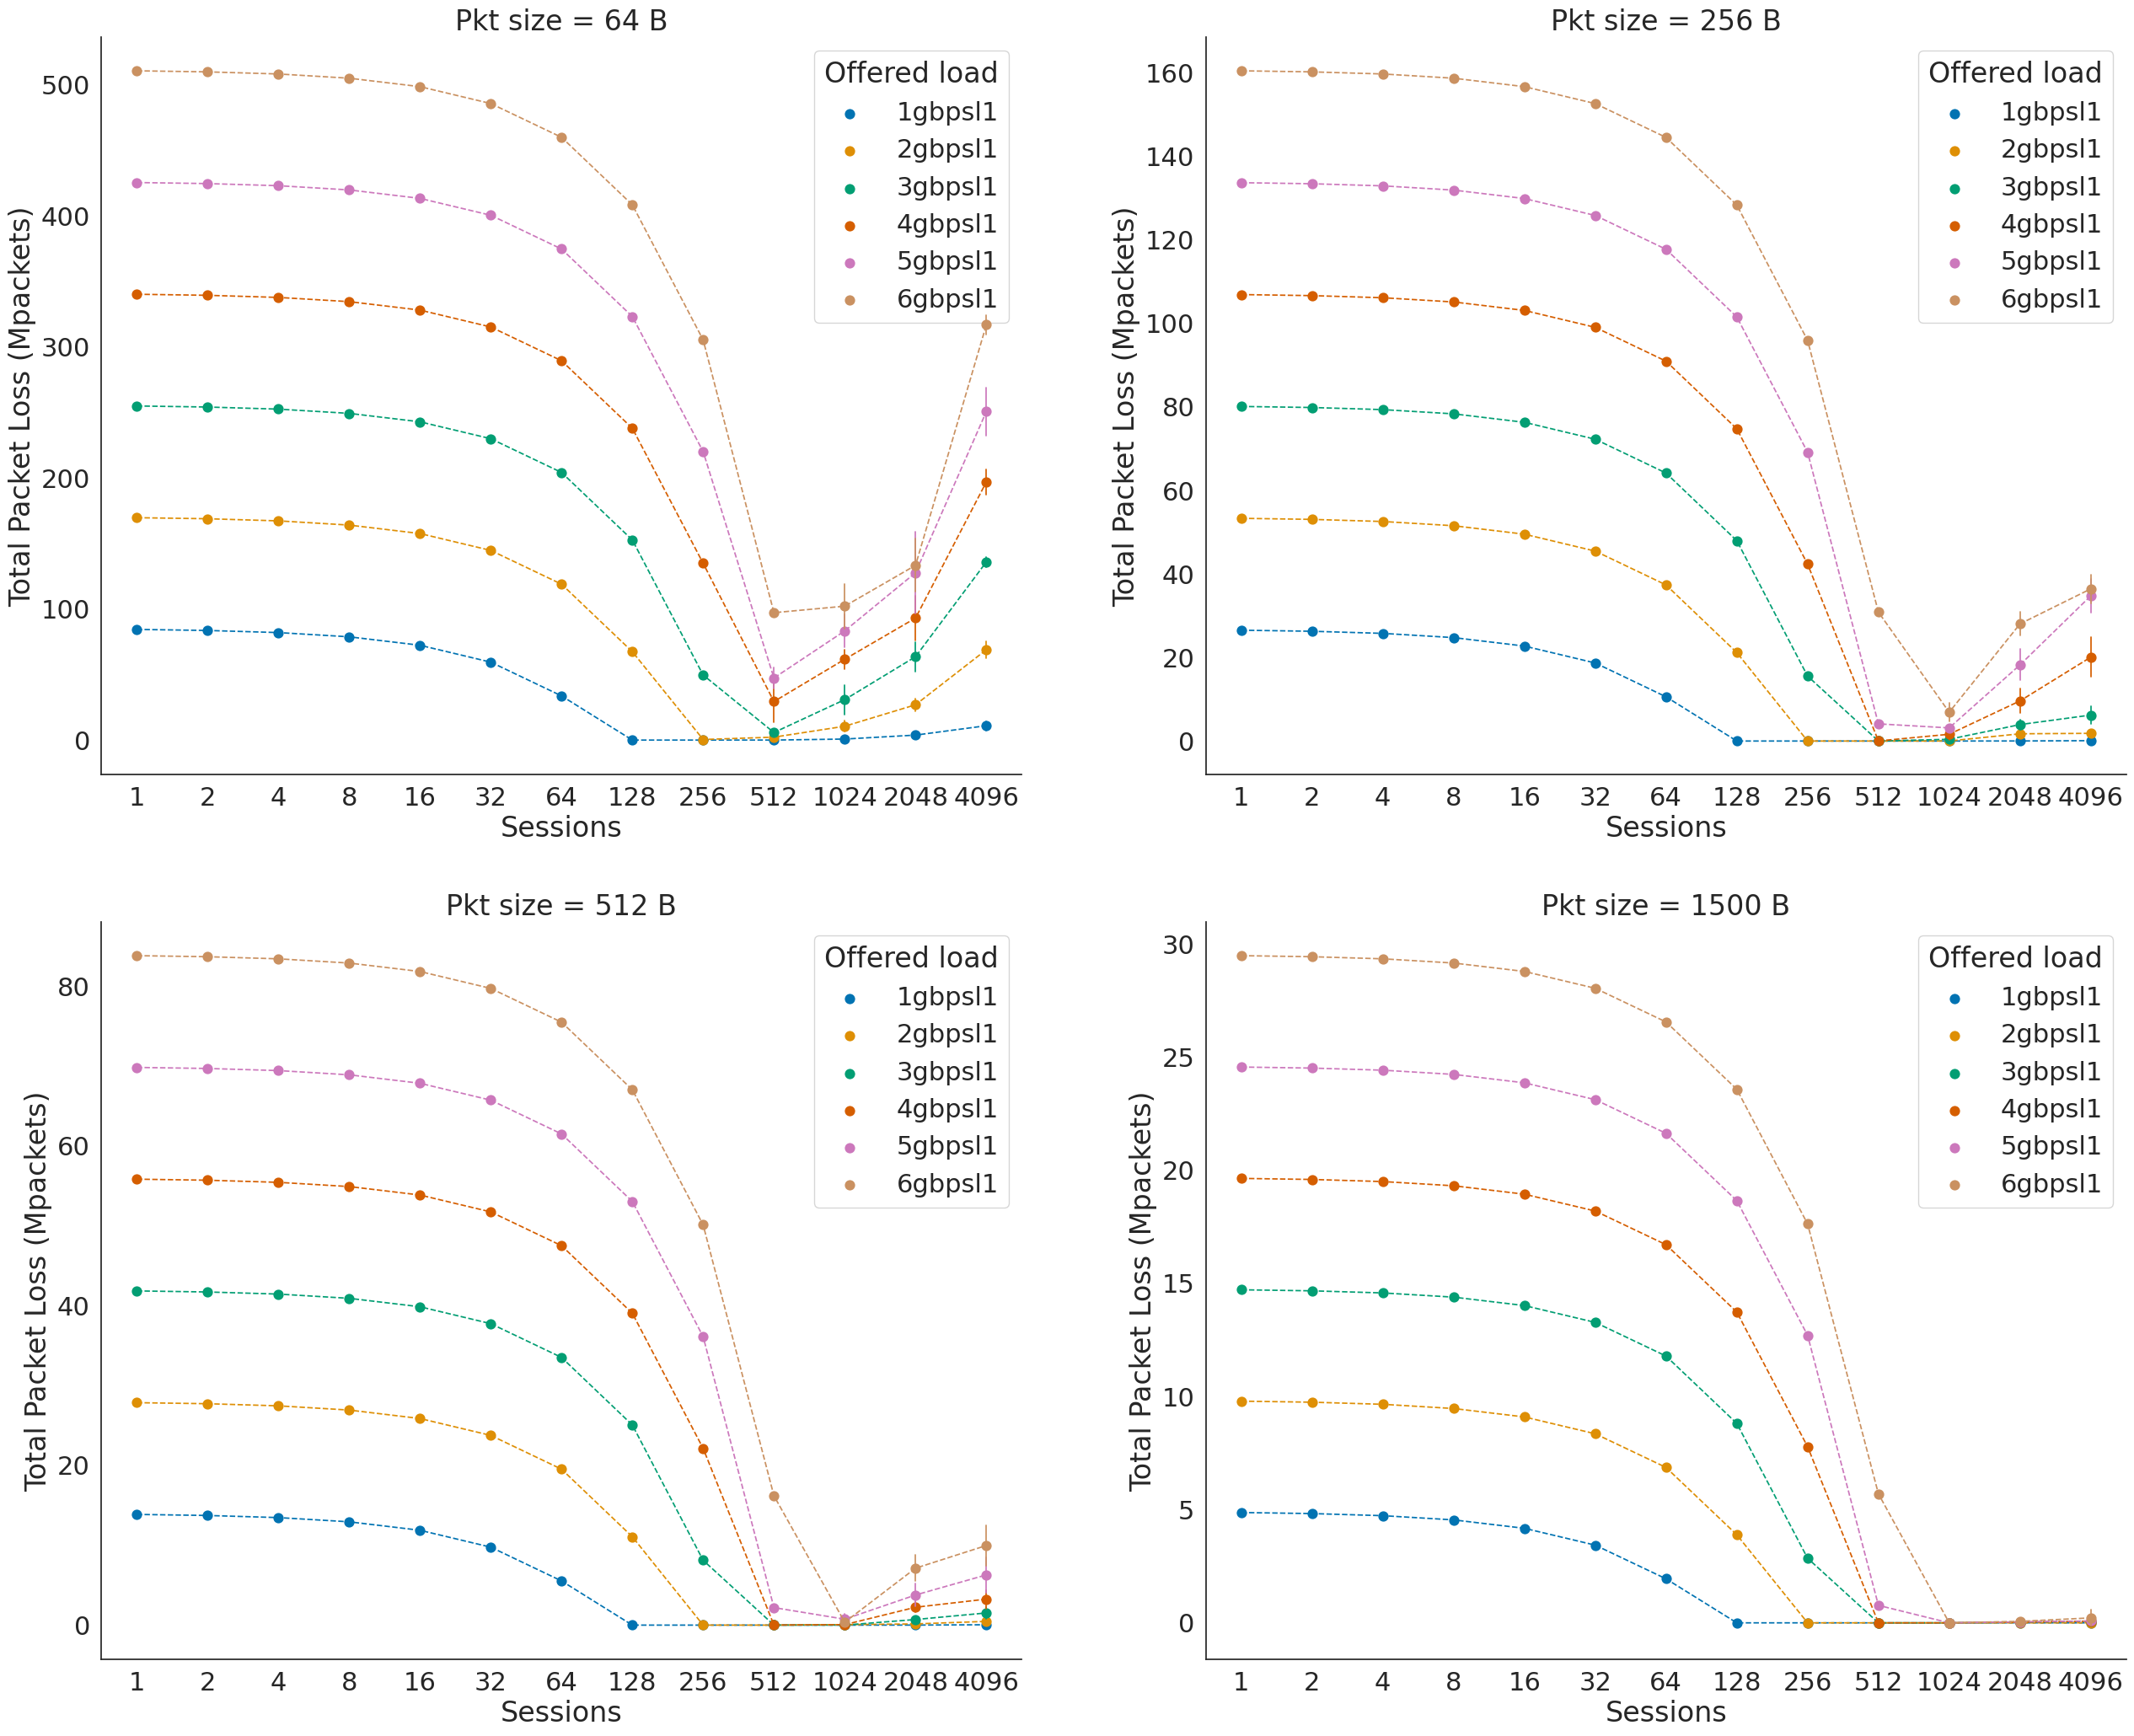

In [7]:
%matplotlib inline
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(31,25))

fig = sns.pointplot(
    data = measurements_df[measurements_df['packet_size'] == 64],
    x = 'flows',
    y = measurements_df['lost_packets']/(10**6),
    hue = 'Offered load',
    units = 'units',
    ax = ax1,
    palette = 'colorblind',
    ci = 'sd',
    err_style = 'bars',
    markersize=1,
    errorwidth=3,
    join = True,
    linestyles = '--',
    linewidth = 0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax1.set(
    ylabel = 'Total Packet Loss (Mpackets)',
    xlabel = 'Sessions',
    title = 'Pkt size = 64 B',
)
plt.setp(fig.lines,linewidth=1.25)

    
fig = sns.pointplot(
    data = measurements_df[measurements_df['packet_size'] == 256],
    x = 'flows',
    y = measurements_df['lost_packets']/(10**6),
    hue = 'Offered load',
    units = 'units',
    ax = ax2,
    palette = 'colorblind',
    ci = 'sd',
    err_style = 'bars',
    markersize=1,
    errorwidth=3,
    join = True,
    linestyles = '--',
    # hue_order = [64, 256, 512, 1500],
)

ax2.set(
    ylabel = 'Total Packet Loss (Mpackets)',
    xlabel = 'Sessions',
    title = 'Pkt size = 256 B',
)
plt.setp(fig.lines,linewidth=1.25)

fig = sns.pointplot(
    data = measurements_df[measurements_df['packet_size'] == 512],
    x = 'flows',
    y = measurements_df['lost_packets']/(10**6),
    hue = 'Offered load',
    units = 'units',
    ax = ax3,
    palette = 'colorblind',
    ci = 'sd',
    err_style = 'bars',
    #dodge = 0.5,
    markersize=1,
    errorwidth=3,
    join = True,
    linestyles = '--',
    # hue_order = [64, 256, 512, 1500]g = sns.factorplot(x="time", y="pulse", hue="kind", data=exercise, scale=.5)
)

ax3.set(
    ylabel = 'Total Packet Loss (Mpackets)',
    xlabel = 'Sessions',
    title = 'Pkt size = 512 B',
)
plt.setp(fig.lines,linewidth=1.25)

fig = sns.pointplot(
    data = measurements_df[measurements_df['packet_size'] == 1500],
    x = 'flows',
    y = measurements_df['lost_packets']/(10**6),
    hue = 'Offered load',
    units = 'units',
    ax = ax4,
    palette = 'colorblind',
    ci = 'sd',
    err_style = 'bars',
    #dodge = 0.5,
    markersize=1,
    errorwidth=3,
    join = True,
    linestyles = '--',
    # hue_order = [64, 256, 512, 1500],
)

ax4.set(
    ylabel = 'Total Packet Loss (Mpackets)',
    xlabel = 'Sessions',
    title = 'Pkt size = 1500 B',
)
plt.setp(fig.lines,linewidth=1.25)

sns.despine()

# fig.get_figure().savefig("../output_figures/vpp-experiments/pktloss_2200.pdf")

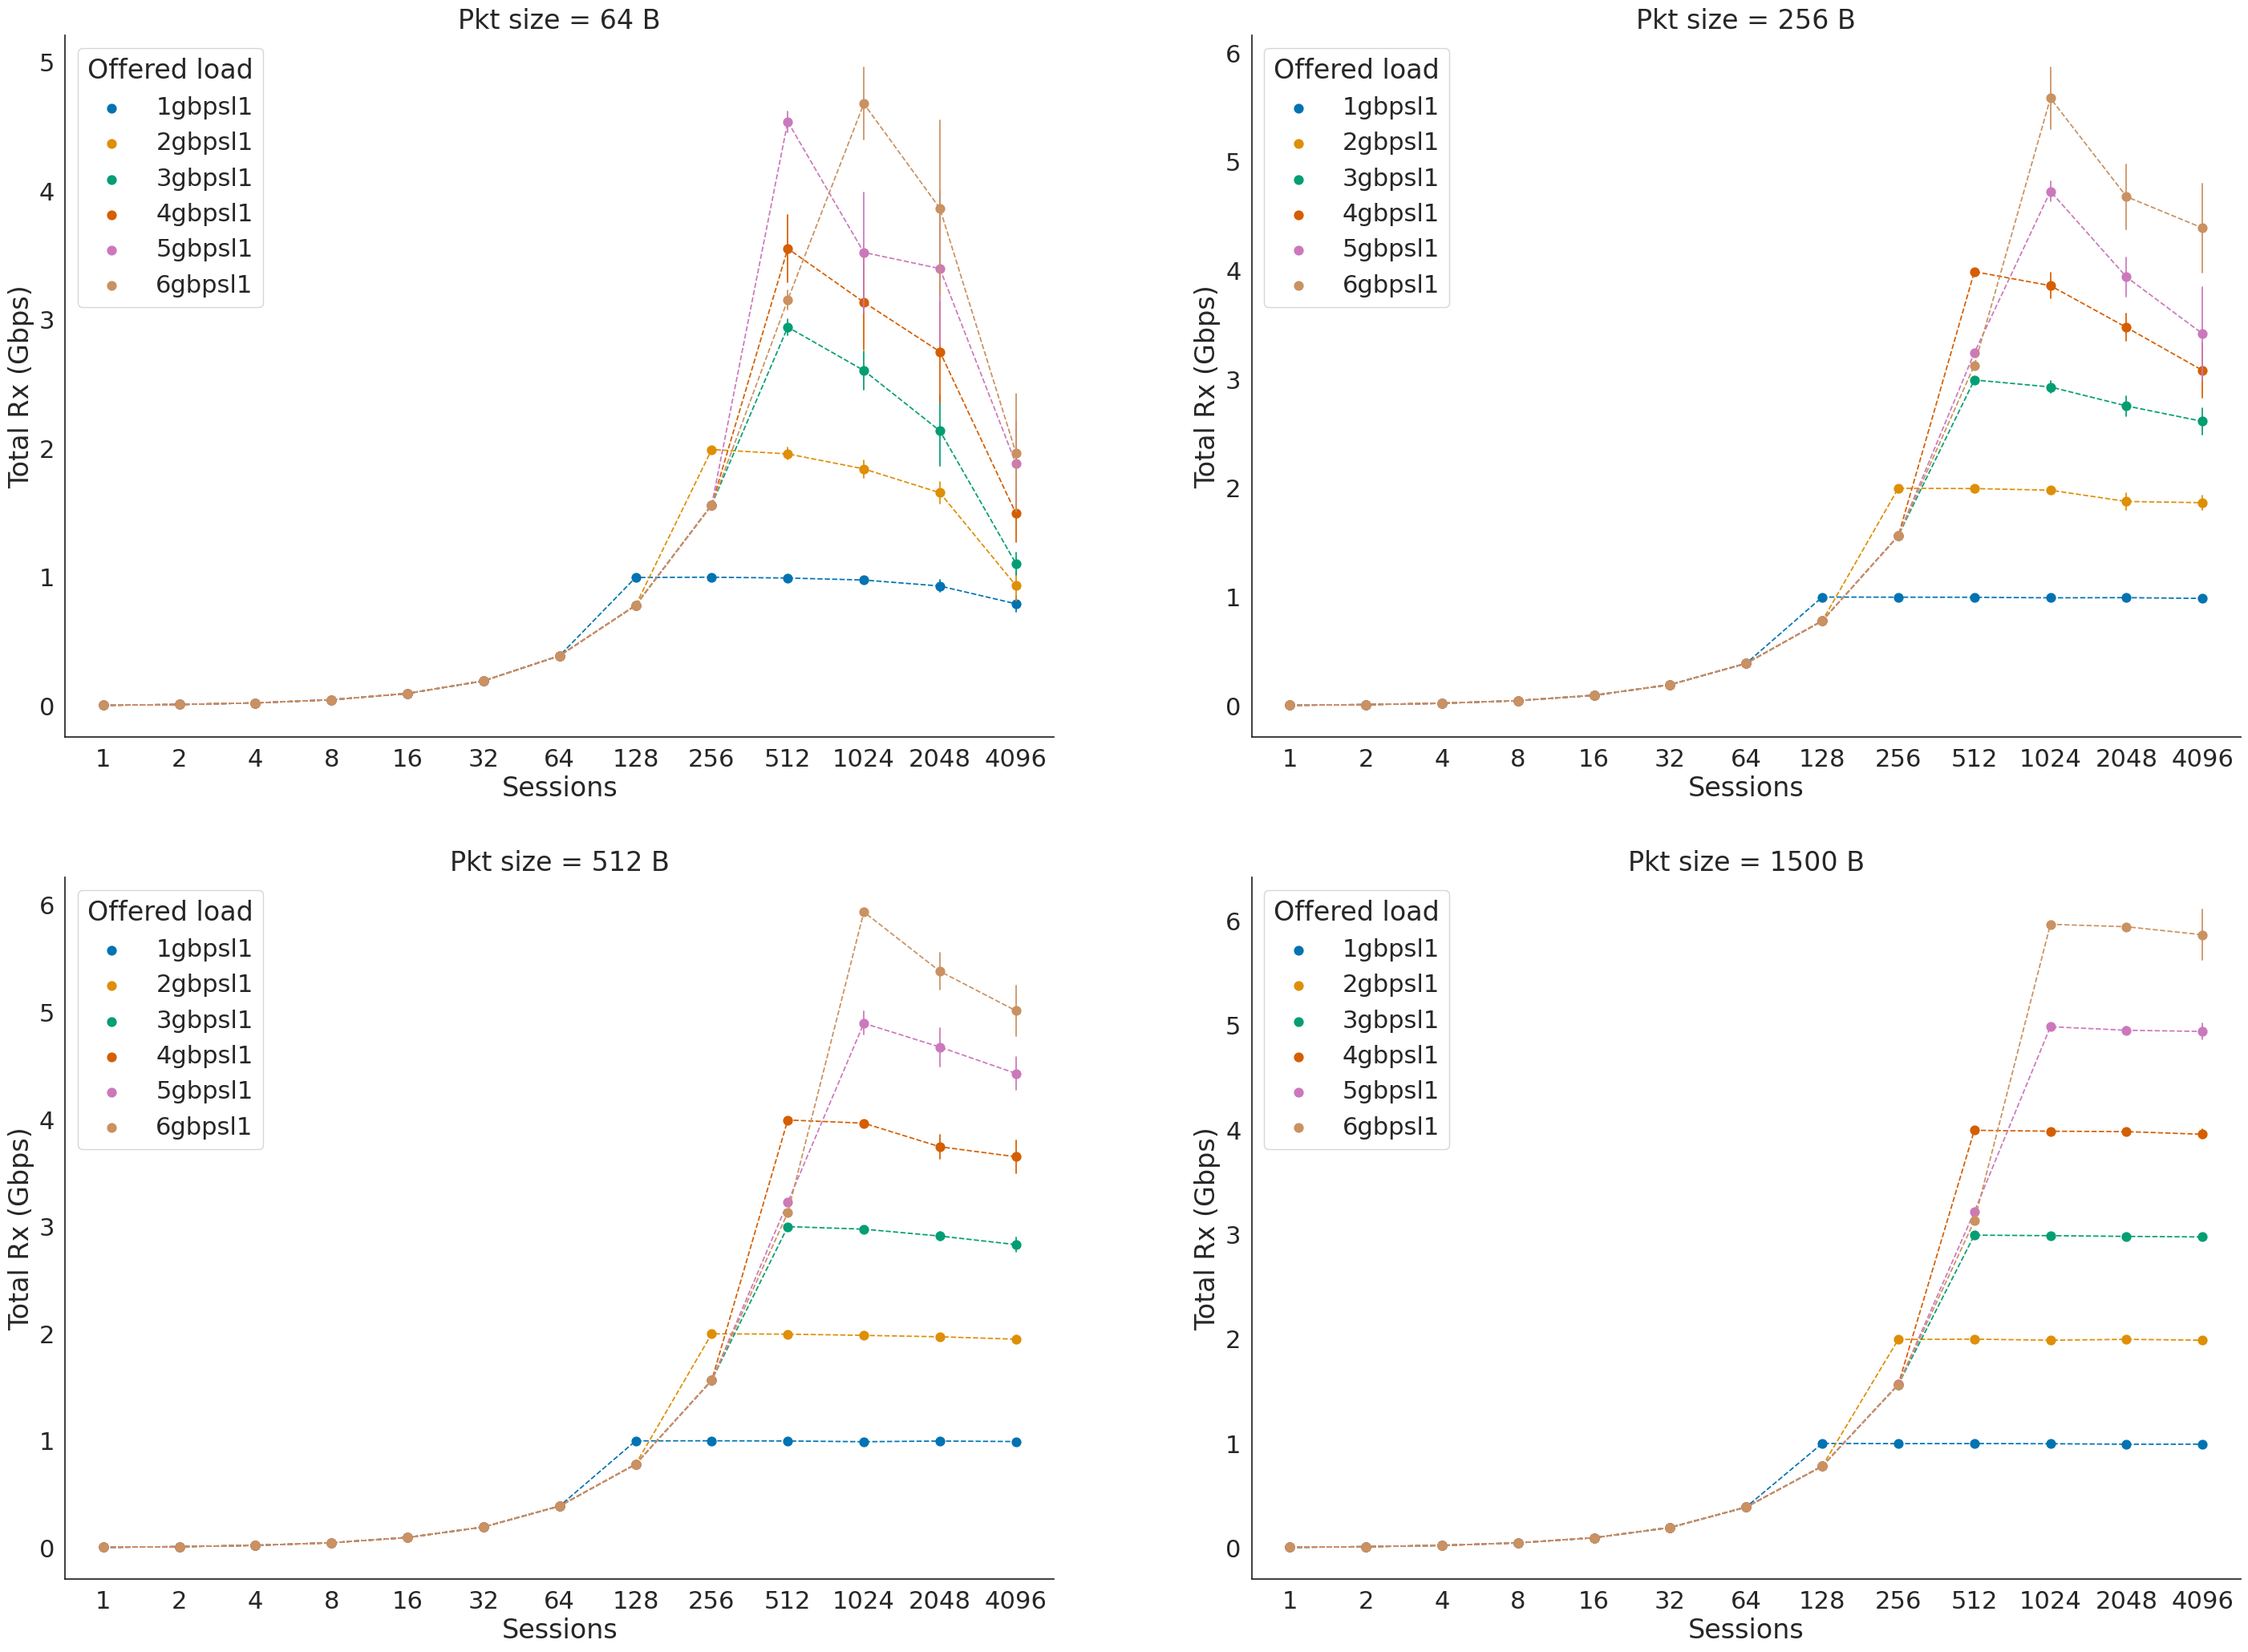

In [8]:
%matplotlib inline
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(35,25))

fig = sns.pointplot(
    data = measurements_df[measurements_df['packet_size'] == 64],
    x = 'flows',
    y = measurements_df['total_rx_L1']/(10**9),
    hue = 'Offered load',
    units = 'units',
    ax = ax1,
    palette = 'colorblind',
    ci = 'sd',
    err_style = 'bars',
    markersize=1,
    errorwidth=3,
    join = True,
    linestyles = '--',
    linewidth = 0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax1.set(
    ylabel = 'Total Rx (Gbps)',
    xlabel = 'Sessions',
    title = 'Pkt size = 64 B',
)
plt.setp(fig.lines,linewidth=1.25)
# plt.legend(title = "Total offered load")

    
fig = sns.pointplot(
    data = measurements_df[measurements_df['packet_size'] == 256],
    x = 'flows',
    # y = measurements_df['total_rx_pps']/(10**6),
    y = measurements_df['total_rx_L1']/(10**9),
    hue = 'Offered load',
    units = 'units',
    ax = ax2,
    palette = 'colorblind',
    ci = 'sd',
    err_style = 'bars',
    markersize=1,
    errorwidth=3,
    join = True,
    linestyles = '--',
    # hue_order = [64, 256, 512, 1500],
)

ax2.set(
    ylabel = 'Total Rx (Gbps)',
    xlabel = 'Sessions',
    title = 'Pkt size = 256 B',
    # ylim = [-0.1, 3],
)
plt.setp(fig.lines,linewidth=1.25)

fig = sns.pointplot(
    data = measurements_df[measurements_df['packet_size'] == 512],
    x = 'flows',
    # y = measurements_df['total_rx_pps']/(10**6),
    y = measurements_df['total_rx_L1']/(10**9),
    hue = 'Offered load',
    units = 'units',
    ax = ax3,
    palette = 'colorblind',
    ci = 'sd',
    err_style = 'bars',
    #dodge = 0.5,
    markersize=1,
    errorwidth=3,
    join = True,
    linestyles = '--',
    # hue_order = [64, 256, 512, 1500]g = sns.factorplot(x="time", y="pulse", hue="kind", data=exercise, scale=.5)
)

ax3.set(
    ylabel = 'Total Rx (Gbps)',
    xlabel = 'Sessions',
    title = 'Pkt size = 512 B',
)
plt.setp(fig.lines,linewidth=1.25)

fig = sns.pointplot(
    data = measurements_df[measurements_df['packet_size'] == 1500],
    x = 'flows',
    # y = measurements_df['total_rx_pps']/(10**6),
    y = measurements_df['total_rx_L1']/(10**9),
    hue = 'Offered load',
    units = 'units',
    ax = ax4,
    palette = 'colorblind',
    ci = 'sd',
    err_style = 'bars',
    #dodge = 0.5,
    markersize=1,
    errorwidth=3,
    join = True,
    linestyles = '--',
    # hue_order = [64, 256, 512, 1500],
)

ax4.set(
    ylabel = 'Total Rx (Gbps)',
    xlabel = 'Sessions',
    title = 'Pkt size = 1500 B',
)
plt.setp(fig.lines,linewidth=1.25)

sns.despine()

# fig.get_figure().savefig("rx_load_pkt_size_2200_bps.png")

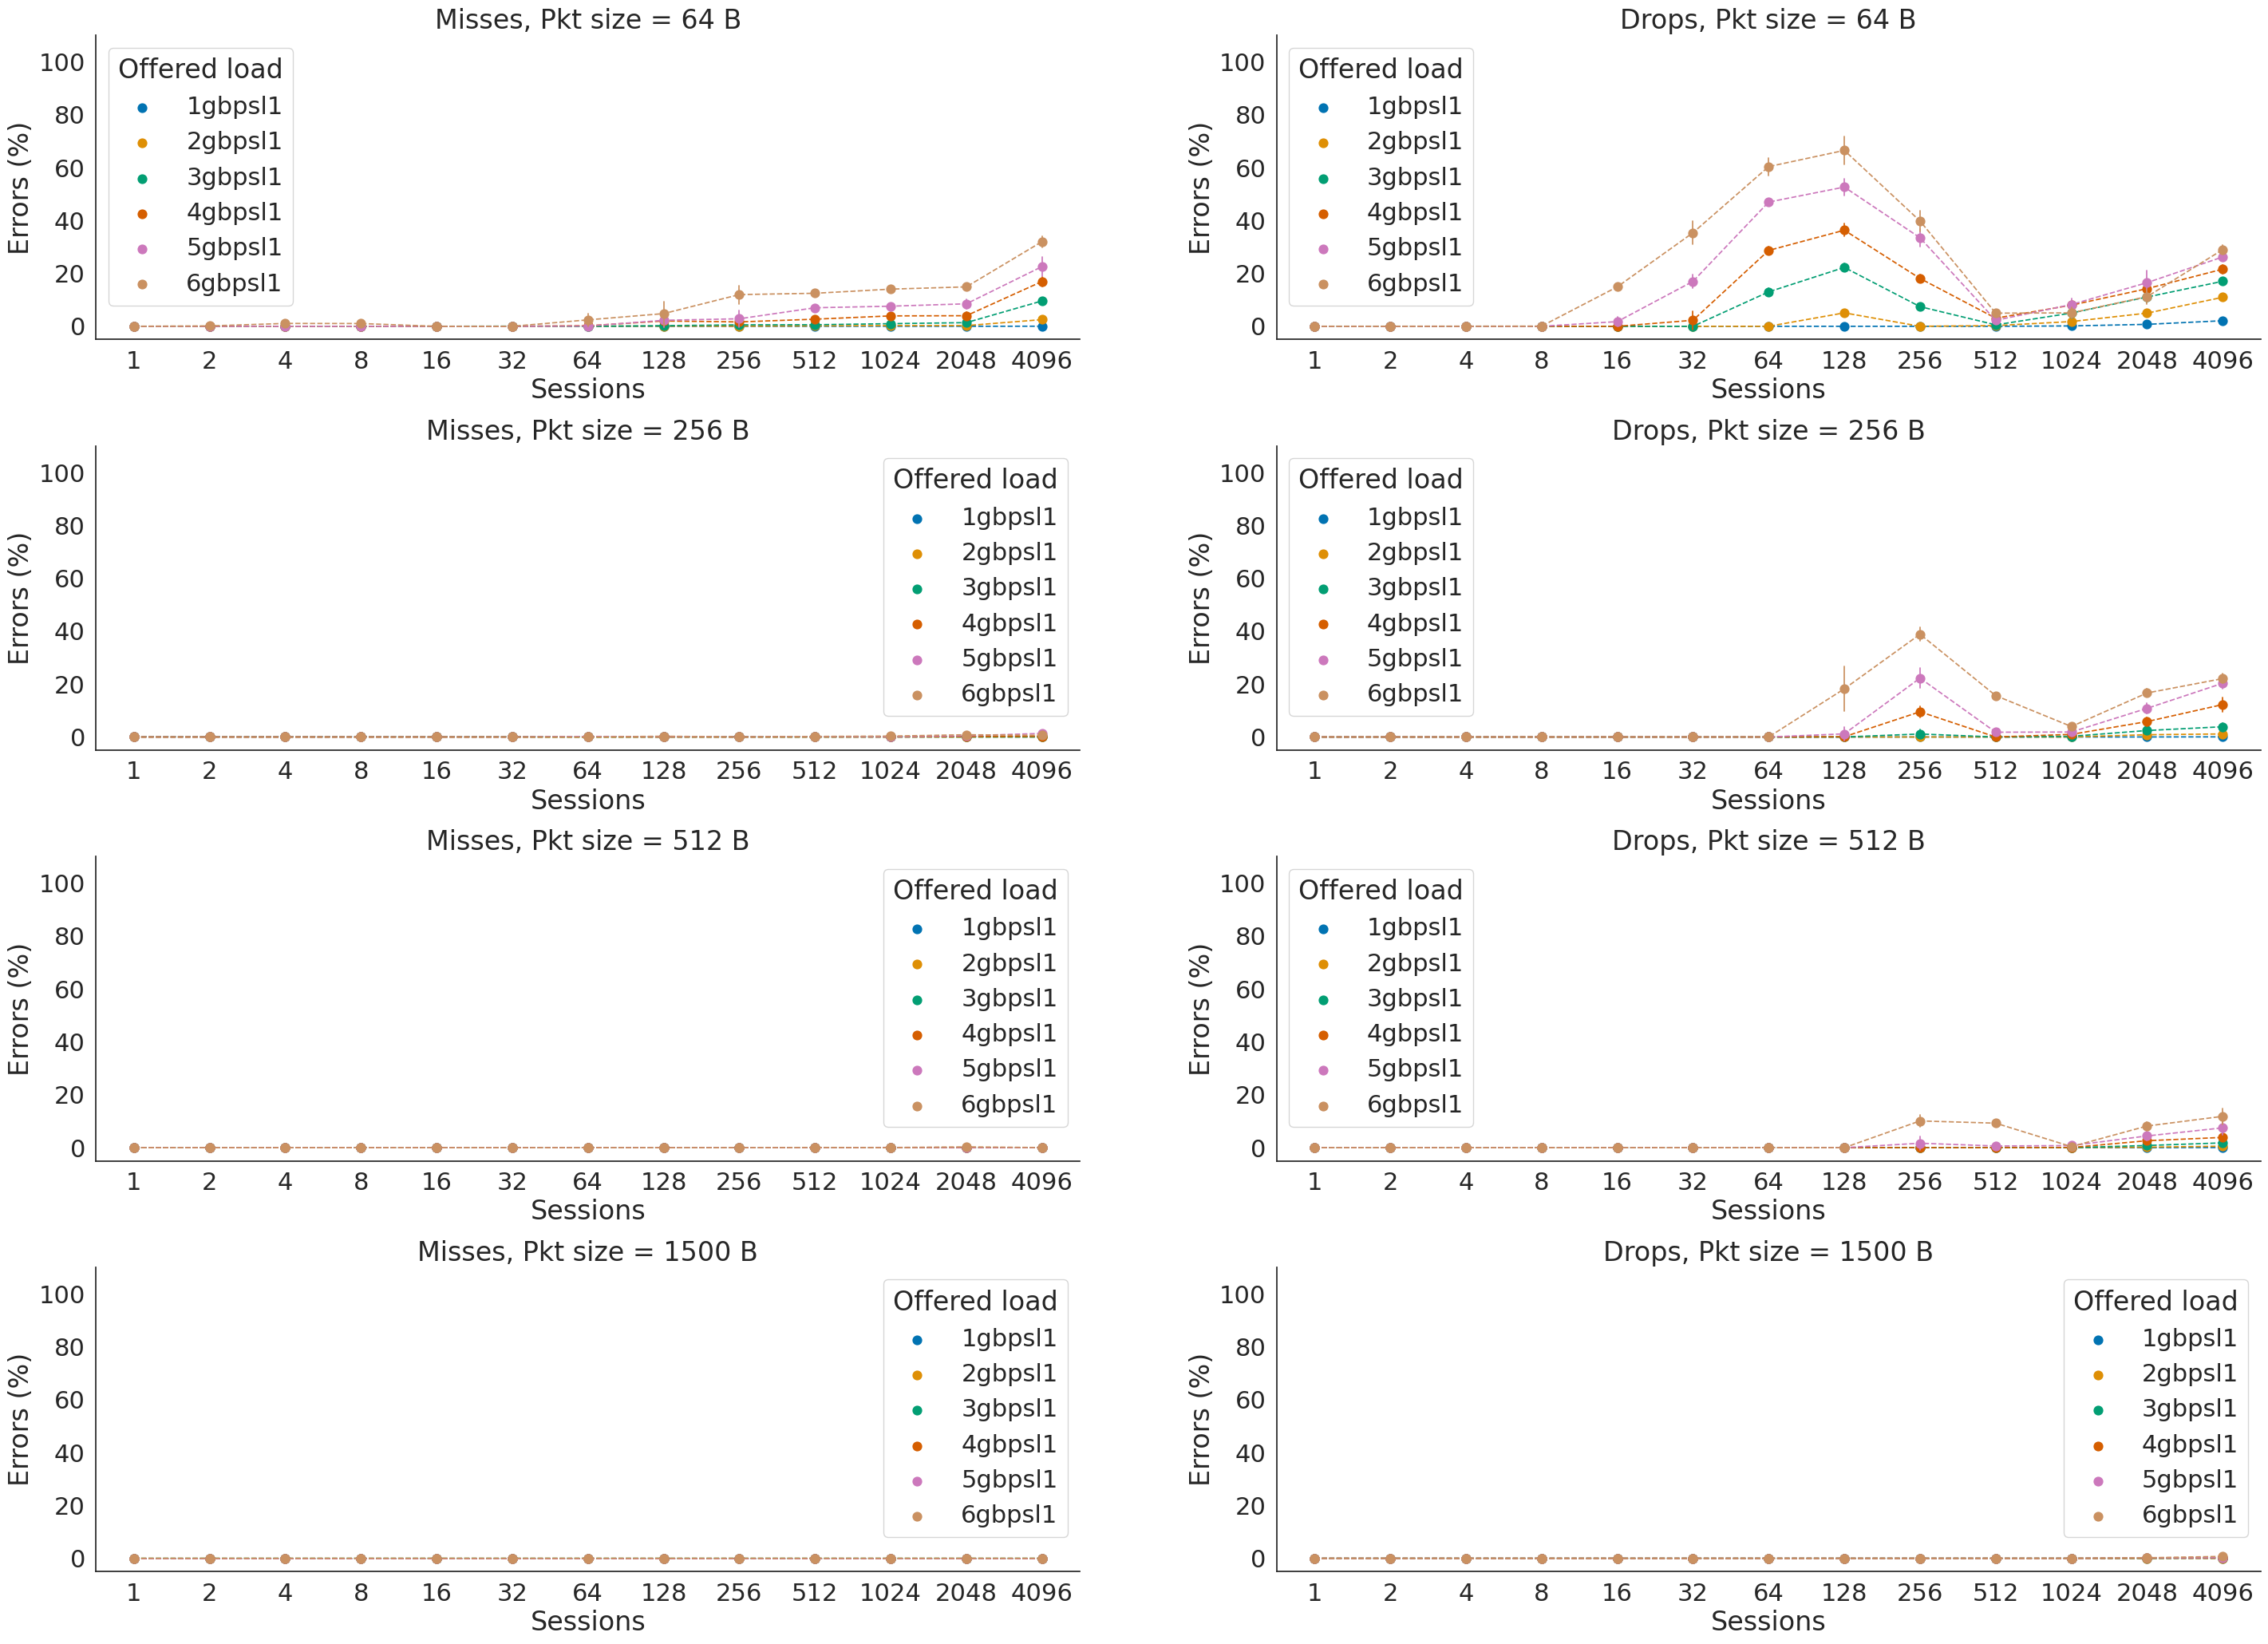

In [9]:
%matplotlib inline
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(nrows=4, ncols=2, figsize=(35,25))

p_df = error_df[error_df['packet_size'] == 64]

fig = sns.pointplot(
    data = p_df[p_df['Error Type'] == 'misses'],
    x = 'flows',
    y = (p_df['Errors']/max(p_df['lost_packets']))*100,
    hue = 'Offered load',
    units = 'units',
    ax = ax1,
    palette = 'colorblind',
    ci = 'sd',
    err_style = 'bars',
    join = True,
    markersize=1,
    errorwidth=3,
    linestyles = '--',
)

ax1.set(
    ylabel = 'Errors (%)',
    xlabel = 'Sessions',
    ylim = [-5, 110],
    title = 'Misses, Pkt size = 64 B',
)
plt.setp(fig.lines,linewidth=1.25)

fig = sns.pointplot(
    data = p_df[p_df['Error Type'] == 'drops'],
    x = 'flows',
    y = (p_df['Errors']/max(p_df['lost_packets']))*100,
    hue = 'Offered load',
    units = 'units',
    ax = ax2,
    palette = 'colorblind',
    ci = 'sd',
    err_style = 'bars',
    join = True,
    markersize=1,
    errorwidth=3,
    linestyles = '--',
)

ax2.set(
    ylabel = 'Errors (%)',
    xlabel = 'Sessions',
    ylim = [-5, 110],
    title = 'Drops, Pkt size = 64 B',
    #ylim = [-0.1, 2],
)
plt.setp(fig.lines,linewidth=1.25)

p_df = error_df[error_df['packet_size'] == 256]

fig = sns.pointplot(
    data = p_df[p_df['Error Type'] == 'misses'],
    x = 'flows',
    y = (p_df['Errors']/max(p_df['lost_packets']))*100,
    hue = 'Offered load',
    units = 'units',
    ax = ax3,
    palette = 'colorblind',
    ci = 'sd',
    err_style = 'bars',
    join = True,
    markersize=1,
    errorwidth=3,
    linestyles = '--',
)

ax3.set(
    ylabel = 'Errors (%)',
    xlabel = 'Sessions',
    ylim = [-5, 110],
    title = 'Misses, Pkt size = 256 B',
    # ylim = [-0.05, 1],
)
plt.setp(fig.lines,linewidth=1.25)

fig = sns.pointplot(
    data = p_df[p_df['Error Type'] == 'drops'],
    x = 'flows',
    y = (p_df['Errors']/max(p_df['lost_packets']))*100,
    hue = 'Offered load',
    units = 'units',
    ax = ax4,
    palette = 'colorblind',
    ci = 'sd',
    err_style = 'bars',
    join = True,
    markersize=1,
    errorwidth=3,
    linestyles = '--',
)

ax4.set(
    ylabel = 'Errors (%)',
    xlabel = 'Sessions',
    ylim = [-5, 110],
    title = 'Drops, Pkt size = 256 B',
)
plt.setp(fig.lines,linewidth=1.25)

p_df = error_df[error_df['packet_size'] == 512]

fig = sns.pointplot(
    data = p_df[p_df['Error Type'] == 'misses'],
    x = 'flows',
    y = (p_df['Errors']/max(p_df['lost_packets']))*100,
    hue = 'Offered load',
    units = 'units',
    ax = ax5,
    palette = 'colorblind',
    ci = 'sd',
    err_style = 'bars',
    join = True,
    markersize=1,
    errorwidth=3,
    linestyles = '--',
)

ax5.set(
    ylabel = 'Errors (%)',
    xlabel = 'Sessions',
    ylim = [-5, 110],
    title = 'Misses, Pkt size = 512 B',
    # ylim = [-0.05, 1],
)
plt.setp(fig.lines,linewidth=1.25)

fig = sns.pointplot(
    data = p_df[p_df['Error Type'] == 'drops'],
    x = 'flows',
    y = (p_df['Errors']/max(p_df['lost_packets']))*100,
    hue = 'Offered load',
    units = 'units',
    ax = ax6,
    palette = 'colorblind',
    ci = 'sd',
    err_style = 'bars',
    join = True,
    markersize=1,
    errorwidth=3,
    linestyles = '--',
)

ax6.set(
    ylabel = 'Errors (%)',
    xlabel = 'Sessions',
    ylim = [-5, 110],
    title = 'Drops, Pkt size = 512 B',
)
plt.setp(fig.lines,linewidth=1.25)

p_df = error_df[error_df['packet_size'] == 1500]

fig = sns.pointplot(
    data = p_df[p_df['Error Type'] == 'misses'],
    x = 'flows',
    y = (p_df['Errors']/max(p_df['lost_packets']))*100,
    hue = 'Offered load',
    units = 'units',
    ax = ax7,
    palette = 'colorblind',
    ci = 'sd',
    err_style = 'bars',
    join = True,
    markersize=1,
    errorwidth=3,
    linestyles = '--',
)

ax7.set(
    ylabel = 'Errors (%)',
    xlabel = 'Sessions',
    ylim = [-5, 110],
    title = 'Misses, Pkt size = 1500 B',
    # ylim = [-0.05, 1],
)
plt.setp(fig.lines,linewidth=1.25)

fig = sns.pointplot(
    data = p_df[p_df['Error Type'] == 'drops'],
    x = 'flows',
    y = (p_df['Errors']/max(p_df['lost_packets']))*100,
    hue = 'Offered load',
    units = 'units',
    ax = ax8,
    palette = 'colorblind',
    ci = 'sd',
    err_style = 'bars',
    join = True,
    markersize=1,
    errorwidth=3,
    linestyles = '--',
)

ax8.set(
    ylabel = 'Errors (%)',
    xlabel = 'Sessions',
    ylim = [-5, 110],
    title = 'Drops, Pkt size = 1500 B',
)
plt.setp(fig.lines,linewidth=1.25)

plt.subplots_adjust(hspace = 0.35)

sns.despine()

# fig.get_figure().savefig("errors_pkt_size_2200.png")

# Experiment 1.2 CPU Frequency changes

Parameters:
- CPU Freq: {1000, 2200, 3000, 4000}
- Sessions: {1, 2, 4, ..., 4096}
- Flows p Session: 2
- TOS per flow: {0 (HP), 1 (LP)}2
- Packet sizes: {64, 256, 512, 1500}

In [20]:
experiment_labels = [
        "1gbpsl1-3000",
        "1gbpsl1-2200",
        "1gbpsl1-1000",
        "2gbpsl1-3000",
        "2gbpsl1-2200",
        "2gbpsl1-1000",
        "3gbpsl1-2200",
        "3gbpsl1-3000",
        "3gbpsl1-1000",
        "4gbpsl1-3000",
        "4gbpsl1-2200",
        "4gbpsl1-1000",
        "5gbpsl1-3000",
        "5gbpsl1-2200",
        "5gbpsl1-1000",
        "6gbpsl1-3000",
        "6gbpsl1-2200",
        "6gbpsl1-1000",
        #"8192-6gbpsl1",
              ]
               
measurements = list()

for experiment in experiment_labels:
    output_dir = f"../output/vpp-flow-{experiment}"
    for direc, sub_direc, files in os.walk(output_dir):

        if 'discarded' in direc:
            continue

        if files == []:
            continue

        if 'old' in direc:
            continue

        t = dict()
        misses = 0
        drops = 0
        vectors = 0
        call = 0

        frequency = experiment.split("-")[1]
        target_load = experiment.split("-")[0]

        for file in files:

            none, flows, packet_size, repeat = direc.replace(output_dir, '').split('/')
            

            if 'vpp' in file:
                with open(direc + '/' + file, "r", encoding="utf8", errors='ignore') as f:
                    for line in f.readlines():
                        p = line.strip().split()
                        if '/interfaces/dev0/rx-miss' in p[-1] and '0' in p[2] and '0' in p[0]:
                            misses = int(p[3])

                        if '/err/dev1-tx/Tx' in p and '2]:' in p[2] and '[0' in p[0]:
                            drops = int(p[3])

                        if '/nodes/dev1-output/vectors' in p and '2]:' in p[2] and '[0' in p[0]:
                            vectors = int(p[3])

                        if '/nodes/dev1-output/calls' in p and '2]:' in p[2] and '[0' in p[0]:
                            calls = int(p[3])

            if 'trex' in file:
                with open(direc + '/' + file, "r") as f:
                    contents = f.read().replace("\n", "").replace("\'", "\"")
                    try:
                        t = ast.literal_eval(contents)
                    except SyntaxError:
                        print(direc + '/' + files[0])
                        continue
            
        pkt_loss = t['total']['opackets']  - t['total']['ipackets']
        measurements.append(
        {
            'total_rx_L1': t['total']['rx_bps_L1'],
            'total_tx_L1': int(t['total']['tx_bps_L1']),
            'total_tx_pps': int(t['total']['tx_pps']),
            'total_rx_pps': int(t['total']['rx_pps']),
            'lost_packets': pkt_loss,
            'tx_util': t['total']['tx_util'],
            'flows': int(flows),
            'packet_size': int(packet_size),
            'misses': misses,
            'drops': drops,
            'misses_normalized': misses/(1 if pkt_loss == 0 else pkt_loss),
            'drops_normalized': drops/(1 if pkt_loss == 0 else pkt_loss),
            'units': repeat,
            'vectors': vectors,
            'call': calls,
            'Offered load': target_load,
            'frequency': int(frequency),
        })

    measurements_df = pd.DataFrame(measurements)

In [21]:
t_df = measurements_df
columns = ['misses', 'drops', 'units']
#columns = ['misses_normalized', 'drops_normalized']
error_df = pd.melt(t_df, id_vars = ['units', 'frequency', 'packet_size', 'flows', 'tx_util', 'lost_packets', 'Offered load'], value_vars = columns).rename(columns = {'variable': 'Error Type', 'value': 'Errors'})

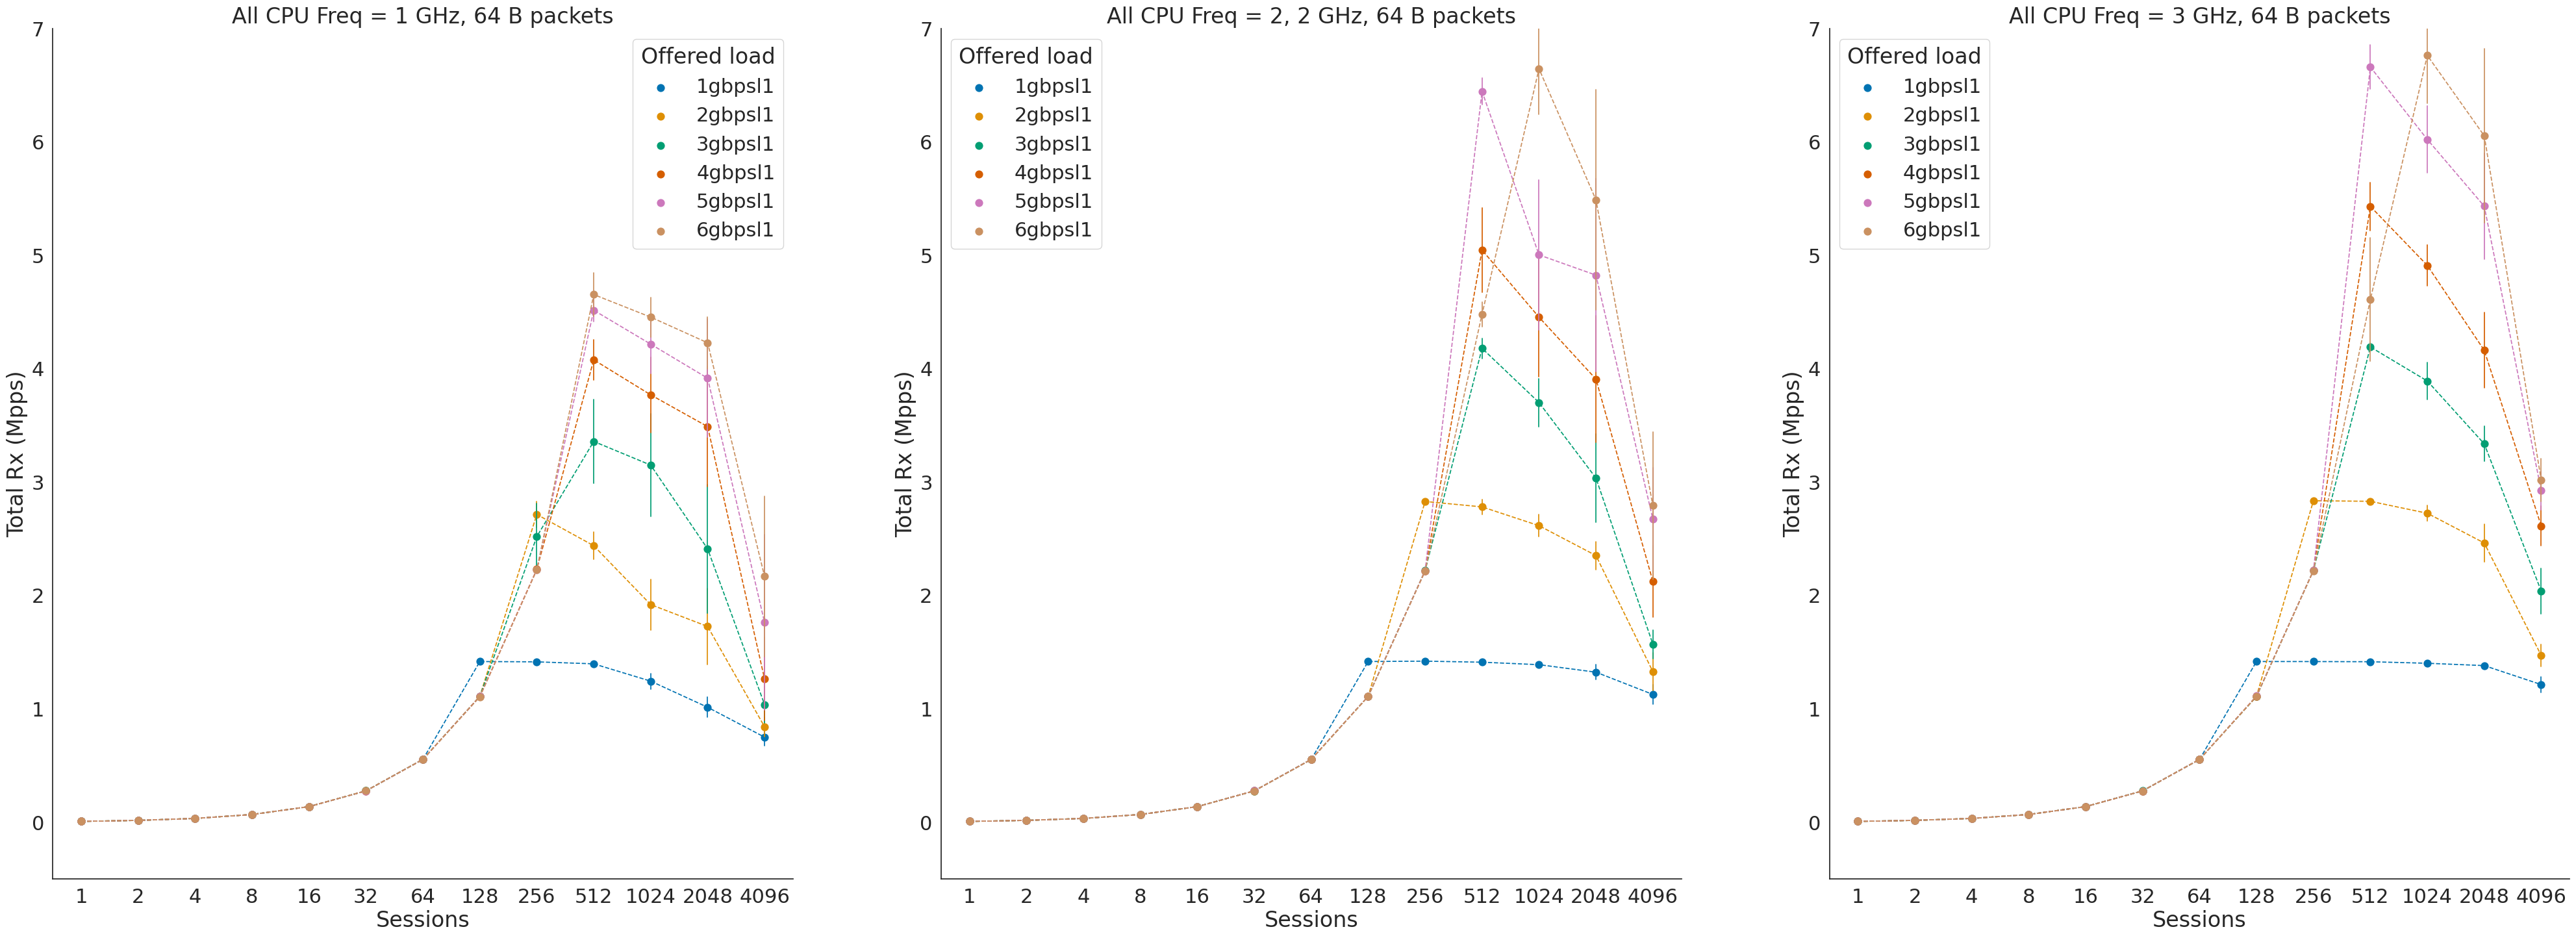

In [25]:
%matplotlib inline
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(50, 17))

t_df = measurements_df[measurements_df['packet_size'] == 64]

fig = sns.pointplot(
    data = t_df[t_df['frequency'] == 1000],
    x = 'flows',
    y = measurements_df['total_rx_pps']/(10**6),
    hue = 'Offered load',
    units = 'units',
    ax = ax1,
    palette = 'colorblind',
    ci = 'sd',
    err_style = 'bars',
    markersize=1,
    errorwidth=3,
    join = True,
    linestyles = '--',
    linewidth = 0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax1.set(
    ylabel = 'Total Rx (Mpps)',
    xlabel = 'Sessions',
    ylim = [-0.5, 7],
    title = 'All CPU Freq = 1 GHz, 64 B packets',
)
plt.setp(fig.lines,linewidth=1.25)
    
fig = sns.pointplot(
    data = t_df[t_df['frequency'] == 2200],
    x = 'flows',
    y = measurements_df['total_rx_pps']/(10**6),
    hue = 'Offered load',
    units = 'units',
    ax = ax2,
    palette = 'colorblind',
    ci = 'sd',
    err_style = 'bars',
    markersize=1,
    errorwidth=3,
    join = True,
    linestyles = '--',
    # hue_order = [64, 256, 512, 1500],
)

ax2.set(
    ylabel = 'Total Rx (Mpps)',
    xlabel = 'Sessions',
    ylim = [-0.5, 7],
    title = 'All CPU Freq = 2, 2 GHz, 64 B packets',
)
plt.setp(fig.lines,linewidth=1.25)

fig = sns.pointplot(
    data = t_df[t_df['frequency'] == 3000],
    x = 'flows',
    y = measurements_df['total_rx_pps']/(10**6),
    hue = 'Offered load',
    units = 'units',
    ax = ax3,
    palette = 'colorblind',
    ci = 'sd',
    err_style = 'bars',
    markersize=1,
    errorwidth=3,
    join = True,
    linestyles = '--',
    # hue_order = [64, 256, 512, 1500],
)

ax3.set(
    ylabel = 'Total Rx (Mpps)',
    xlabel = 'Sessions',
    title = 'All CPU Freq = 3 GHz, 64 B packets',
    ylim = [-0.5, 7],
)
plt.setp(fig.lines,linewidth=1.25)

sns.despine()

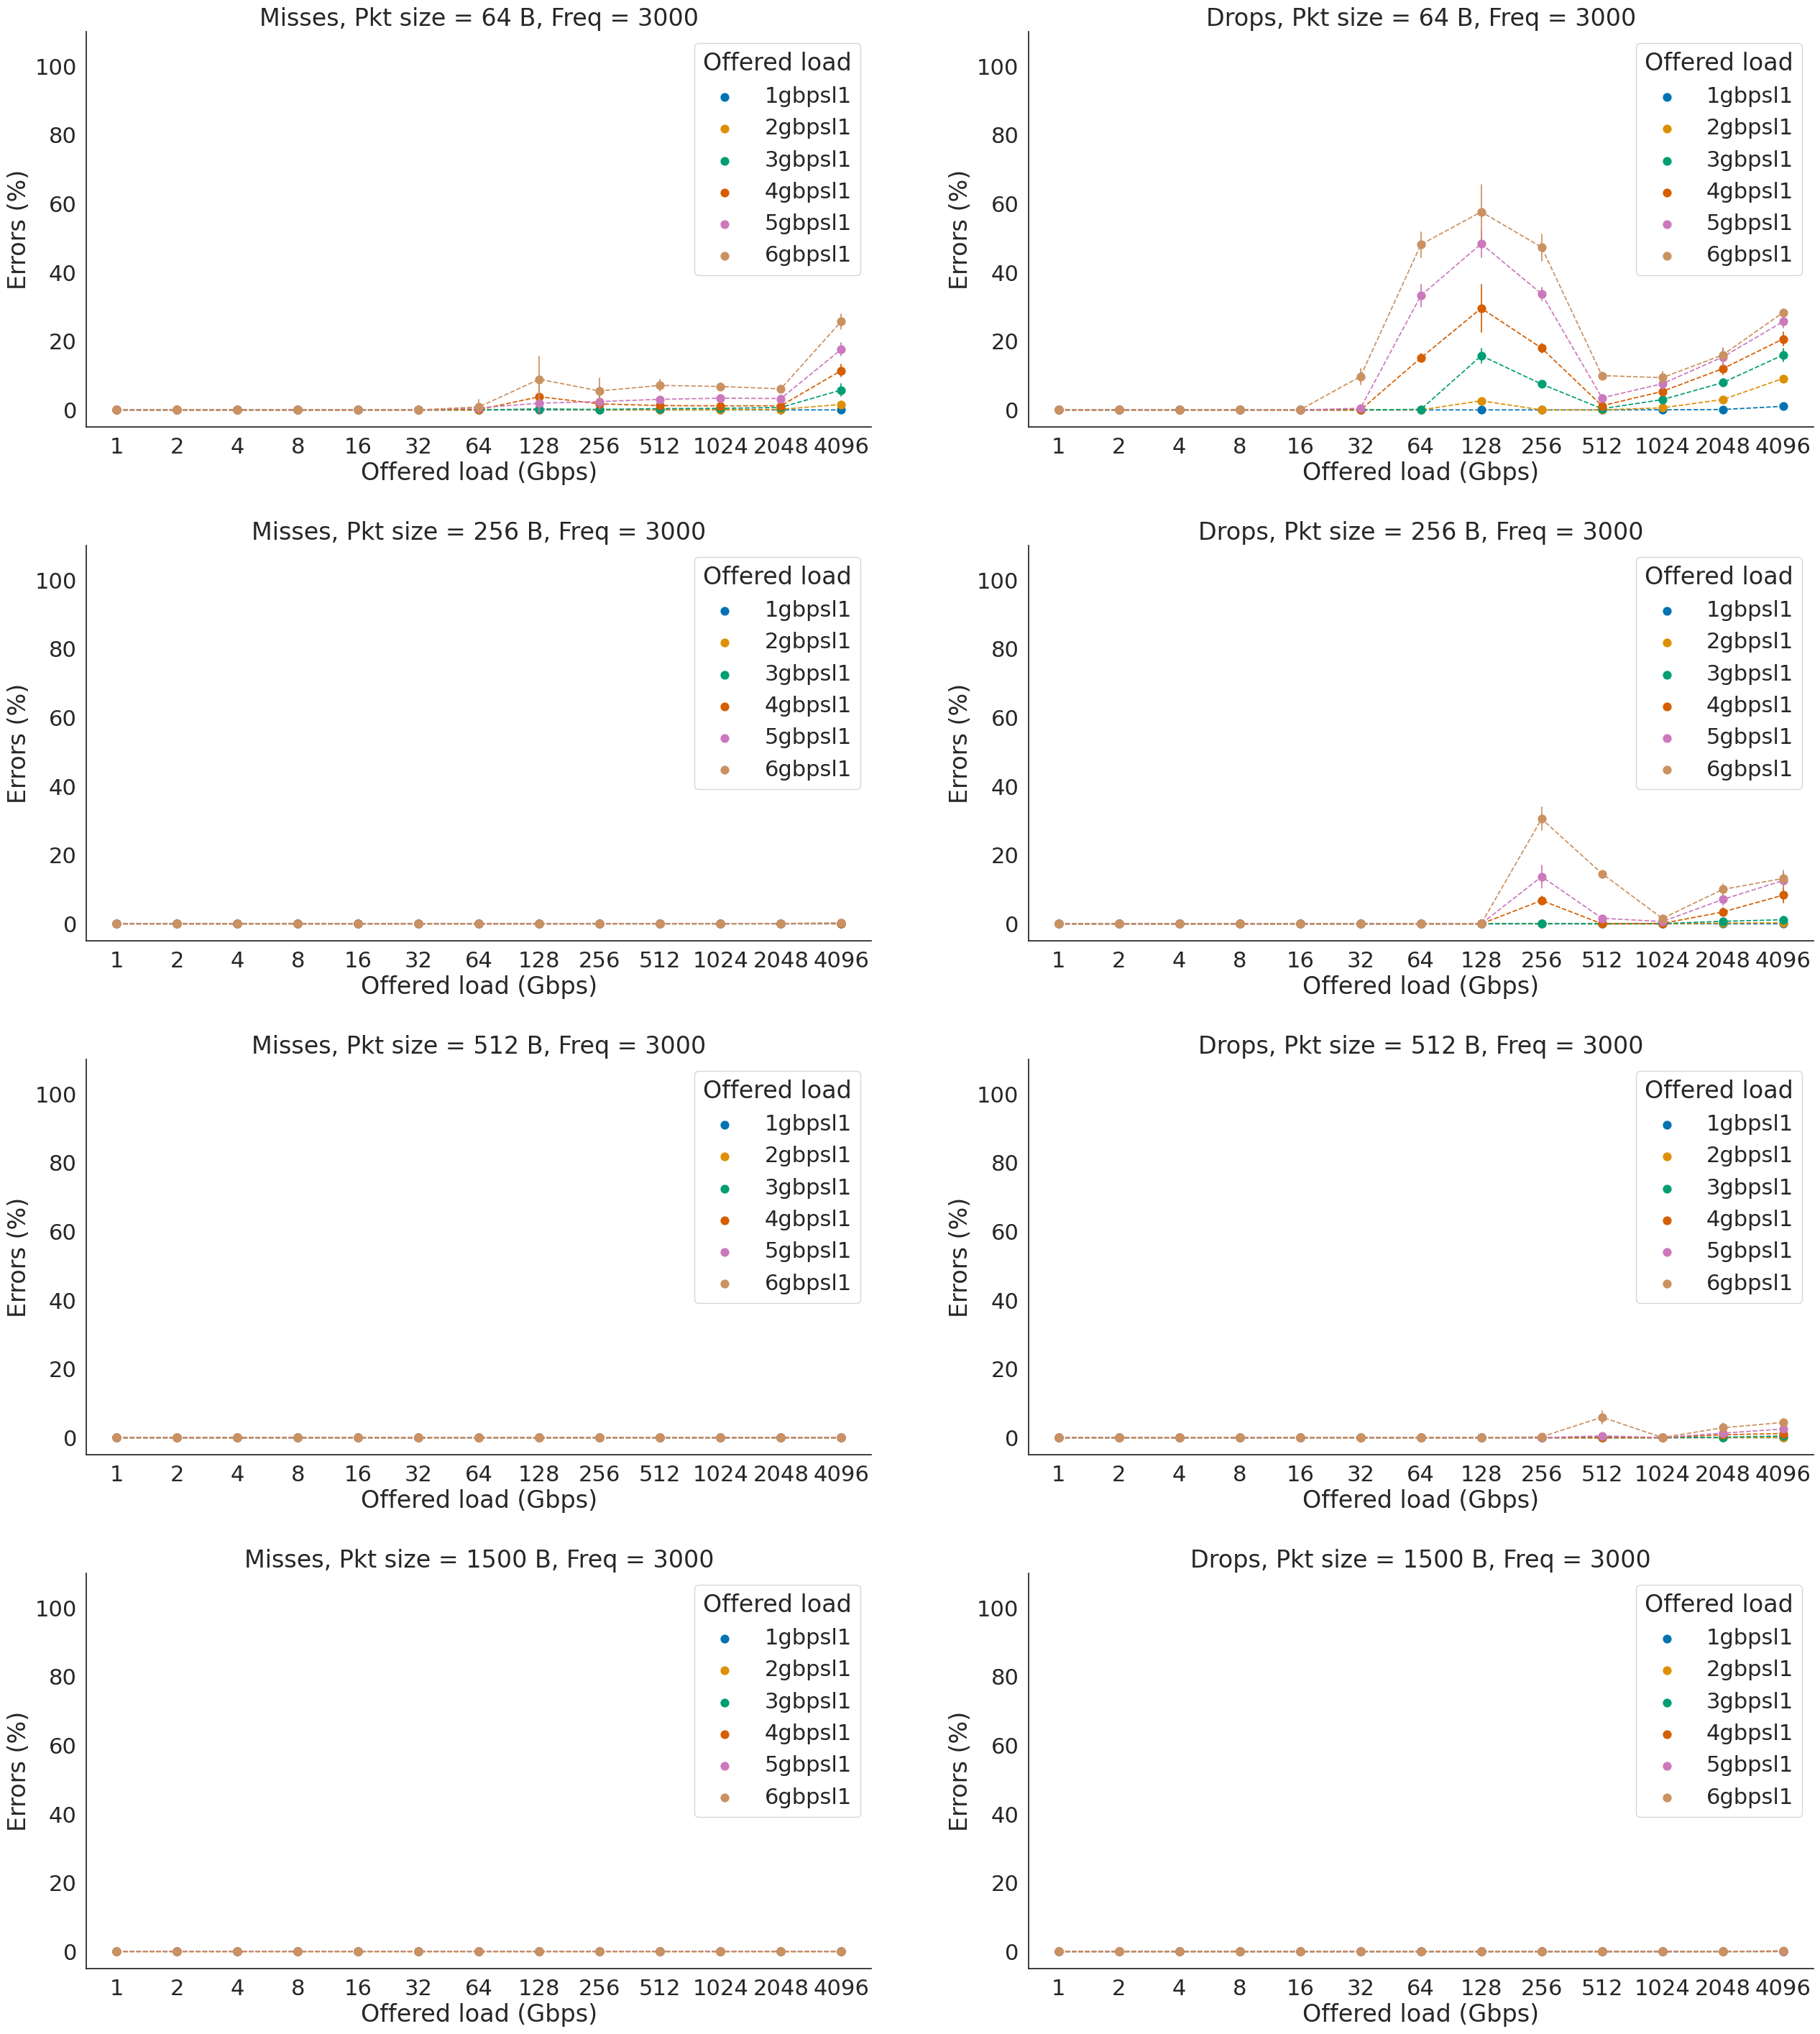

In [26]:
%matplotlib inline
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(nrows=4, ncols=2, figsize=(31,35))

FREQ=3000

PKT_SIZE=64
p_df = error_df[error_df['packet_size'] == PKT_SIZE]
p_df = p_df[p_df['frequency'] == FREQ]

fig = sns.pointplot(
    data = p_df[p_df['Error Type'] == 'misses'],
    x = 'flows',
    y = (p_df['Errors']/max(p_df['lost_packets']))*100,
    hue = 'Offered load',
    units = 'units',
    ax = ax1,
    palette = 'colorblind',
    ci = 'sd',
    err_style = 'bars',
    join = True,
    markersize=1,
    errorwidth=3,
    linestyles = '--',
)

ax1.set(
    ylabel = 'Errors (%)',
    xlabel = 'Offered load (Gbps)',
    ylim = [-5, 110],
    title = f'Misses, Pkt size = {PKT_SIZE} B, Freq = {FREQ}',
)
plt.setp(fig.lines,linewidth=1.25)

fig = sns.pointplot(
    data = p_df[p_df['Error Type'] == 'drops'],
    x = 'flows',
    y = (p_df['Errors']/max(p_df['lost_packets']))*100,
    hue = 'Offered load',
    units = 'units',
    ax = ax2,
    palette = 'colorblind',
    ci = 'sd',
    err_style = 'bars',
    join = True,
    markersize=1,
    errorwidth=3,
    linestyles = '--',
)

ax2.set(
    ylabel = 'Errors (%)',
    xlabel = 'Offered load (Gbps)',
    ylim = [-5, 110],
    title = f'Drops, Pkt size = {PKT_SIZE} B, Freq = {FREQ}',
    #ylim = [-0.1, 2],
)
plt.setp(fig.lines,linewidth=1.25)

PKT_SIZE=256
p_df = error_df[error_df['packet_size'] == PKT_SIZE]
p_df = p_df[p_df['frequency'] == FREQ]

fig = sns.pointplot(
    data = p_df[p_df['Error Type'] == 'misses'],
    x = 'flows',
    y = (p_df['Errors']/max(p_df['lost_packets']))*100,
    hue = 'Offered load',
    units = 'units',
    ax = ax3,
    palette = 'colorblind',
    ci = 'sd',
    err_style = 'bars',
    join = True,
    markersize=1,
    errorwidth=3,
    linestyles = '--',
)

ax3.set(
    ylabel = 'Errors (%)',
    xlabel = 'Offered load (Gbps)',
    ylim = [-5, 110],
    title = f'Misses, Pkt size = {PKT_SIZE} B, Freq = {FREQ}',
    # ylim = [-0.05, 1],
)
plt.setp(fig.lines,linewidth=1.25)

fig = sns.pointplot(
    data = p_df[p_df['Error Type'] == 'drops'],
    x = 'flows',
    y = (p_df['Errors']/max(p_df['lost_packets']))*100,
    hue = 'Offered load',
    units = 'units',
    ax = ax4,
    palette = 'colorblind',
    ci = 'sd',
    err_style = 'bars',
    join = True,
    markersize=1,
    errorwidth=3,
    linestyles = '--',
)

ax4.set(
    ylabel = 'Errors (%)',
    xlabel = 'Offered load (Gbps)',
    ylim = [-5, 110],
    title = f'Drops, Pkt size = {PKT_SIZE} B, Freq = {FREQ}',
)
plt.setp(fig.lines,linewidth=1.25)

PKT_SIZE=512
p_df = error_df[error_df['packet_size'] == PKT_SIZE]
p_df = p_df[p_df['frequency'] == FREQ]

fig = sns.pointplot(
    data = p_df[p_df['Error Type'] == 'misses'],
    x = 'flows',
    y = (p_df['Errors']/max(p_df['lost_packets']))*100,
    hue = 'Offered load',
    units = 'units',
    ax = ax5,
    palette = 'colorblind',
    ci = 'sd',
    err_style = 'bars',
    join = True,
    markersize=1,
    errorwidth=3,
    linestyles = '--',
)

ax5.set(
    ylabel = 'Errors (%)',
    xlabel = 'Offered load (Gbps)',
    ylim = [-5, 110],
    title = f'Misses, Pkt size = {PKT_SIZE} B, Freq = {FREQ}',
    # ylim = [-0.05, 1],
)
plt.setp(fig.lines,linewidth=1.25)

fig = sns.pointplot(
    data = p_df[p_df['Error Type'] == 'drops'],
    x = 'flows',
    y = (p_df['Errors']/max(p_df['lost_packets']))*100,
    hue = 'Offered load',
    units = 'units',
    ax = ax6,
    palette = 'colorblind',
    ci = 'sd',
    err_style = 'bars',
    join = True,
    markersize=1,
    errorwidth=3,
    linestyles = '--',
)

ax6.set(
    ylabel = 'Errors (%)',
    xlabel = 'Offered load (Gbps)',
    ylim = [-5, 110],
    title = f'Drops, Pkt size = {PKT_SIZE} B, Freq = {FREQ}',
)
plt.setp(fig.lines,linewidth=1.25)

PKT_SIZE=1500
p_df = error_df[error_df['packet_size'] == PKT_SIZE]
p_df = p_df[p_df['frequency'] == FREQ]

fig = sns.pointplot(
    data = p_df[p_df['Error Type'] == 'misses'],
    x = 'flows',
    y = (p_df['Errors']/max(p_df['lost_packets']))*100,
    hue = 'Offered load',
    units = 'units',
    ax = ax7,
    palette = 'colorblind',
    ci = 'sd',
    err_style = 'bars',
    join = True,
    markersize=1,
    errorwidth=3,
    linestyles = '--',
)

ax7.set(
    ylabel = 'Errors (%)',
    xlabel = 'Offered load (Gbps)',
    ylim = [-5, 110],
    title = f'Misses, Pkt size = {PKT_SIZE} B, Freq = {FREQ}',
    # ylim = [-0.05, 1],
)
plt.setp(fig.lines,linewidth=1.25)

fig = sns.pointplot(
    data = p_df[p_df['Error Type'] == 'drops'],
    x = 'flows',
    y = (p_df['Errors']/max(p_df['lost_packets']))*100,
    hue = 'Offered load',
    units = 'units',
    ax = ax8,
    palette = 'colorblind',
    ci = 'sd',
    err_style = 'bars',
    join = True,
    markersize=1,
    errorwidth=3,
    linestyles = '--',
)

ax8.set(
    ylabel = 'Errors (%)',
    xlabel = 'Offered load (Gbps)',
    ylim = [-5, 110],
    title = f'Drops, Pkt size = {PKT_SIZE} B, Freq = {FREQ}',
)
plt.setp(fig.lines,linewidth=1.25)

plt.subplots_adjust(hspace = 0.3)

sns.despine()

# fig.get_figure().savefig(f"../output_figures/{FREQ}_misses_drops.pdf")

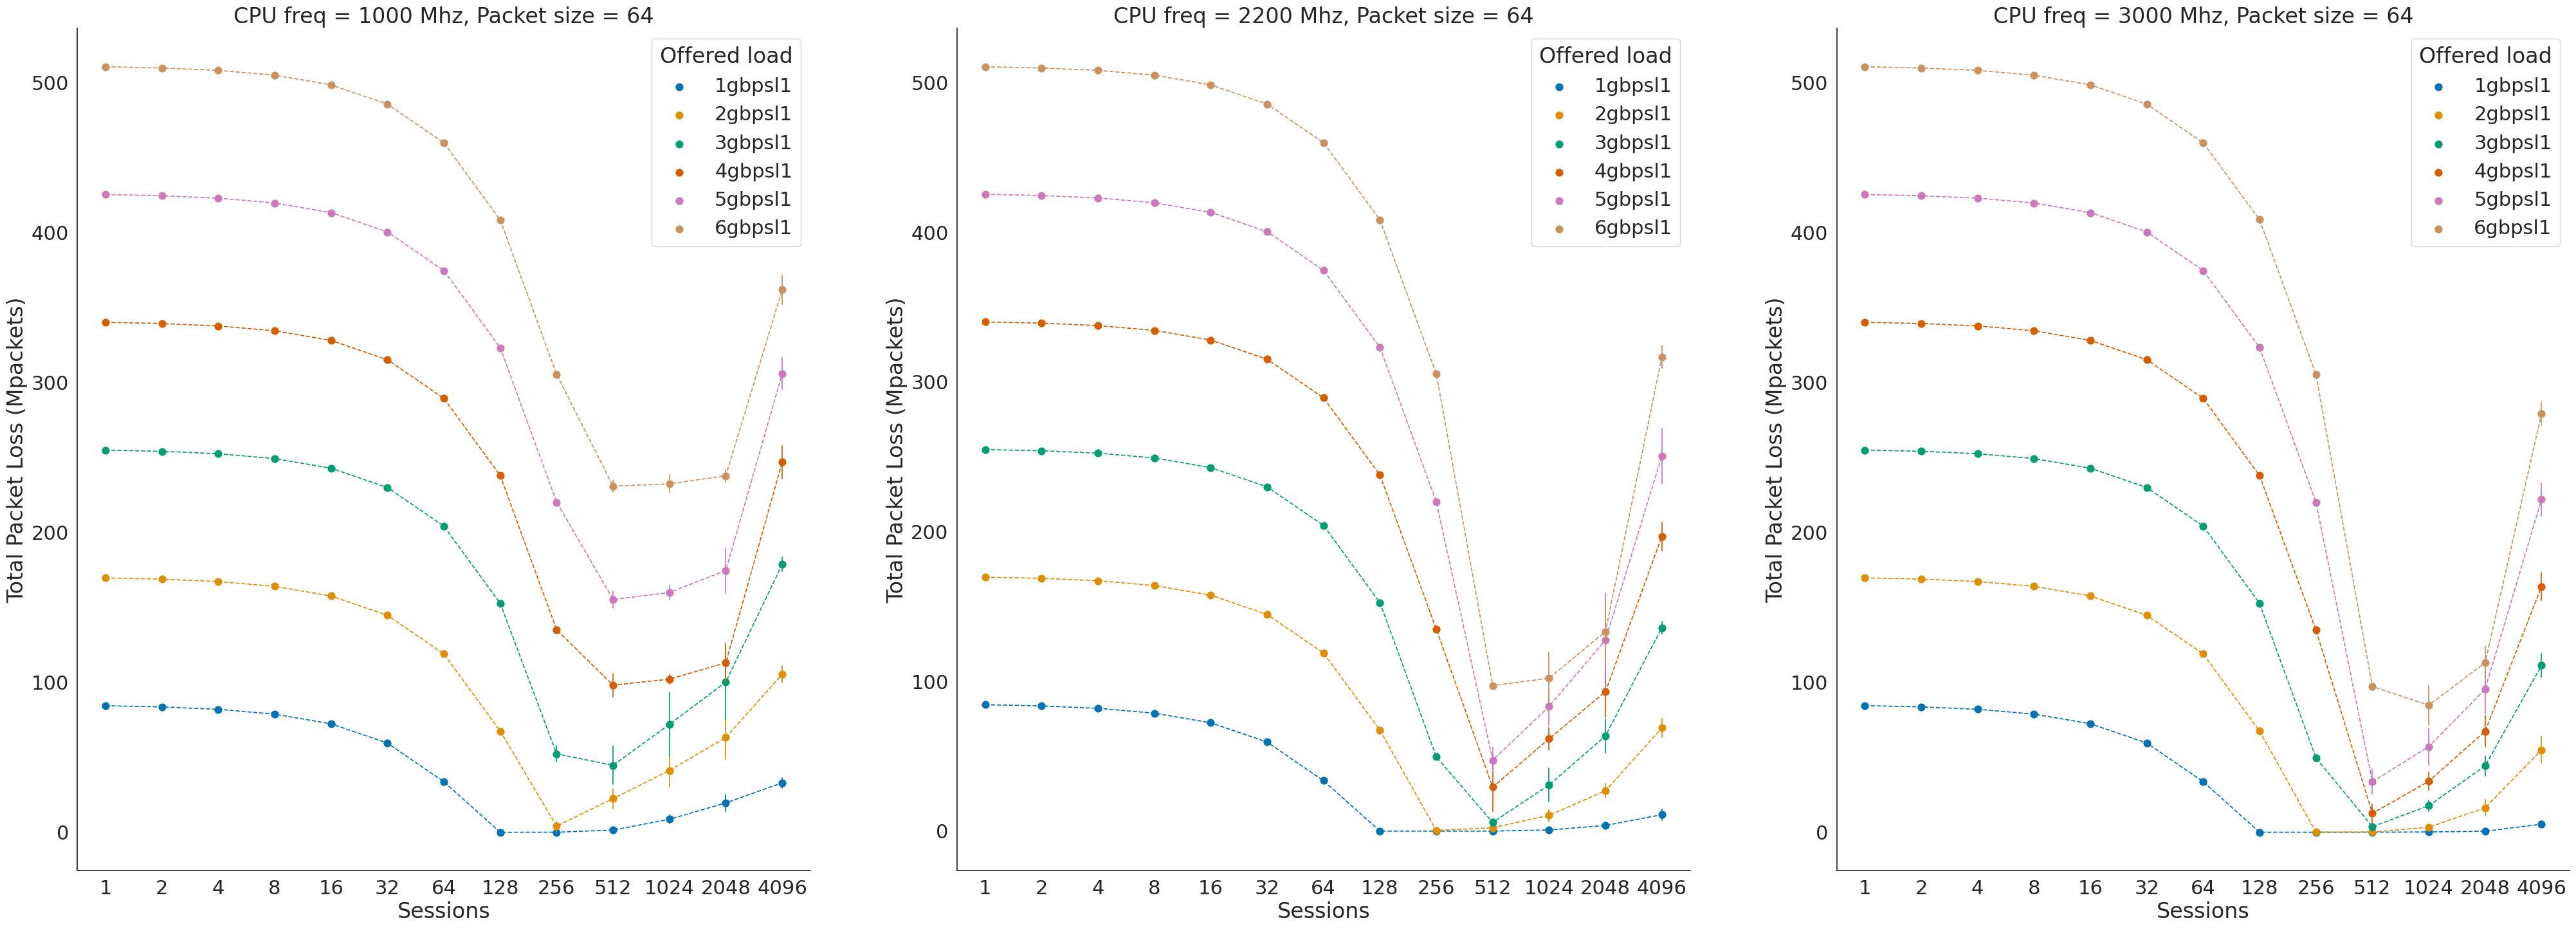

In [27]:
%matplotlib inline
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(50, 17))

PKT_SIZE=64

p_df = error_df[error_df['packet_size'] == PKT_SIZE]

FREQ=1000
fig = sns.pointplot(
    data =  p_df[p_df['frequency'] == FREQ],
    x = 'flows',
    y = p_df['lost_packets']/(10**6),
    hue = 'Offered load',
    units = 'units',
    ax = ax1,
    palette = 'colorblind',
    ci = 'sd',
    err_style = 'bars',
    markersize=1,
    errorwidth=3,
    join = True,
    linestyles = '--',
    linewidth = 0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax1.set(
    ylabel = 'Total Packet Loss (Mpackets)',
    xlabel = 'Sessions',
    title = f'CPU freq = {FREQ} Mhz, Packet size = {PKT_SIZE}',
)
plt.setp(fig.lines,linewidth=1.25)

FREQ=2200
fig = sns.pointplot(
    data =  p_df[p_df['frequency'] == FREQ],
    x = 'flows',
    y = p_df['lost_packets']/(10**6),
    hue = 'Offered load',
    units = 'units',
    ax = ax2,
    palette = 'colorblind',
    ci = 'sd',
    err_style = 'bars',
    markersize=1,
    errorwidth=3,
    join = True,
    linestyles = '--',
    # hue_order = [64, 256, 512, 1500],
)

ax2.set(
    ylabel = 'Total Packet Loss (Mpackets)',
    xlabel = 'Sessions',
    title = f'CPU freq = {FREQ} Mhz, Packet size = {PKT_SIZE}',
)
plt.setp(fig.lines,linewidth=1.25)

FREQ=3000
fig = sns.pointplot(
    data =  p_df[p_df['frequency'] == FREQ],
    x = 'flows',
    y = p_df['lost_packets']/(10**6),
    hue = 'Offered load',
    units = 'units',
    ax = ax3,
    palette = 'colorblind',
    ci = 'sd',
    err_style = 'bars',
    #dodge = 0.5,
    markersize=1,
    errorwidth=3,
    join = True,
    linestyles = '--',
    # hue_order = [64, 256, 512, 1500]
)

ax3.set(
    ylabel = 'Total Packet Loss (Mpackets)',
    xlabel = 'Sessions',
    title = f'CPU freq = {FREQ} Mhz, Packet size = {PKT_SIZE}',
)
plt.setp(fig.lines,linewidth=1.25)

sns.despine()

# fig.get_figure().savefig("../output_figures/freq_total_packetloss_pkt_size64.pdf")

- The maximum advertised CPU freq, 4000 Mhz is not supported. The CPU reports the max allowed freq as 4 Ghz, but when setting with the `./power.py -r 1-27,29-55 -g powersave -M 1000 -m 1000` command, turbostat does show a max of 3000 Mhz. This is *likely* due to a throttle on the temp, or max power draw reached.

# Experiment 1.3 Max NDR throughput with HQoS Bypass

Parameters:
- CPU Freq: 2200
- Sessions: {1, 2, 4, ..., 4096}
- Flows p Session: 2
- TOS per flow: {0 (HP), 1 (LP)}2
- Packet sizes: {64, 256, 512, 1500}

In [4]:
measurements = list()

output_dir = f"../output/ndr-bypass-single"
for direc, sub_direc, files in os.walk(output_dir):

    if 'discarded' in direc:
        continue

    if files == []:
        continue

    if 'old' in direc:
        continue

    t = dict()
    misses = 0
    drops = 0
    vectors = 0
    call = 0
    no_buf = 0

    for file in files:

        none, flows, packet_size, repeat = direc.replace(output_dir, '').split('/')

        if 'vpp' in file:
            with open(direc + '/' + file, "r", encoding="utf8", errors='ignore') as f:
                for line in f.readlines():
                    p = line.strip().split()
                    if '/interfaces/dev0/rx-miss' in p[-1] and '0' in p[2] and '0' in p[0]:
                        misses = int(p[3])
                        
                    if '/interfaces/dev0/rx-no-buf' in p[-1] and '0' in p[2] and '0' in p[0]:
                        no_buf = int(p[3])

                    if '/err/dev1-tx/Tx' in p and '2]:' in p[2] and '[0' in p[0]:
                        drops = int(p[3])

                    if '/nodes/dev1-output/vectors' in p and '2]:' in p[2] and '[0' in p[0]:
                        vectors = int(p[3])

                    if '/nodes/dev1-output/calls' in p and '2]:' in p[2] and '[0' in p[0]:
                        calls = int(p[3])

        if 'trex' in file:
            with open(direc + '/' + file, "r") as f:
                contents = f.read().replace("\n", "").replace("\'", "\"")
                try:
                    t = json.loads(contents)
                except SyntaxError:
                    print(direc + '/' + files[0])
                    continue
                    
    total_errors = misses + drops + no_buf
    measurements.append(
    {
        'total_rx_L1': t['results']['total_tx_L1'],
        'total_tx_L1': int(t['results']['total_rx_L1']),
        'total_tx_pps': int(t['results']['tx_pps']),
        'total_rx_pps': int(t['results']['rx_pps']),
        'flows': int(flows),
        'packet_size': int(packet_size),
        'misses': misses,
        'drops': drops,
        'no_buf': no_buf,
        'total_errors': total_errors,
        'units': repeat,
        'vectors': vectors,
        'call': calls,
    })

bypass_df = pd.DataFrame(measurements)

In [5]:
pps = [(pkt, ((10**11)/8)/pkt/(10**6)) for pkt in [64, 256, 512, 1500]]
pps_df = pd.DataFrame(pps)
pps_df = pps_df.rename(columns={0: 'packet_size', 1: 'pps'})

packet_size         pps
0           64  195.312500
1          256   48.828125
2          512   24.414062
3         1500    8.333333

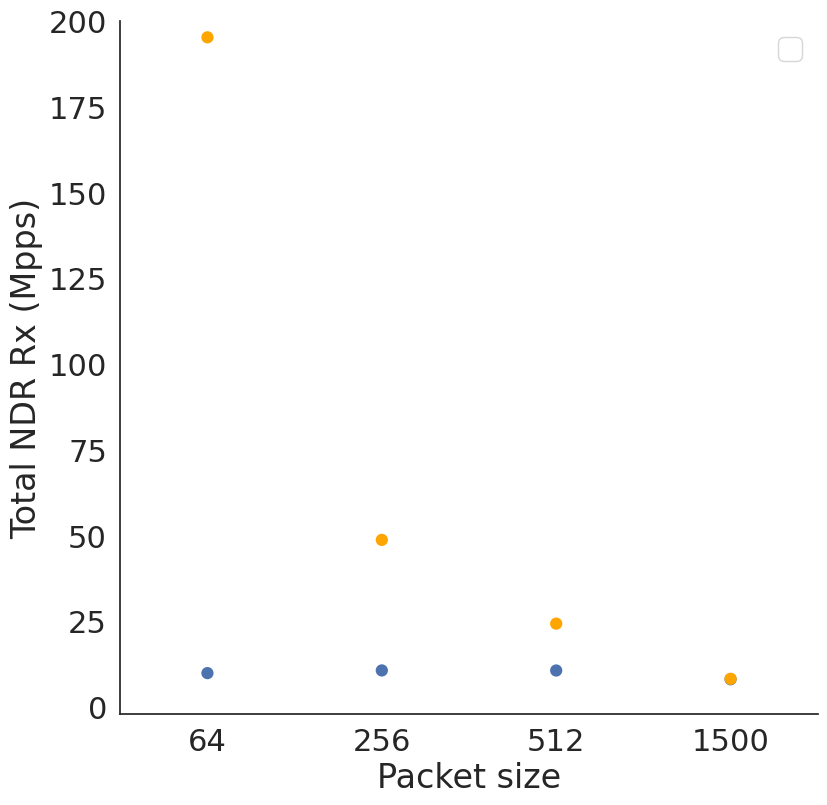

In [34]:
%matplotlib inline
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(9,9))

FREQ=2200

fig1 = sns.pointplot(
    data = bypass_df,
    x = 'packet_size',
    y = bypass_df['total_rx_pps']/(10**6),
    units = 'units',
    ax = ax1,
    #palette = 'colorblind',
    ci = 'sd',
    err_style = 'bars',
    markersize=1,
    errorwidth=3,
    join = False,
    linestyles = '--',
    linewidth = 0.005,
    label = 'Measured',
    # hue_order = [64, 256, 512, 1500],
)

fig2 = sns.pointplot(
    data = pps_df,
    x = 'packet_size',
    y = 'pps',
    ax = ax1,
    #palette = 'colorblind',
    color = 'orange',
    ci = 'sd',
    err_style = 'bars',
    markersize=1,
    errorwidth=3,
    join = False,
    linestyles = '--',
    linewidth = 0.005,
    label = 'Line Rate',

    # hue_order = [64, 256, 512, 1500],
)

ax1.set(
    ylabel = 'Total NDR Rx (Mpps)',
    xlabel = 'Packet size',
    ylim = [-2, 200],
    #title = f'CPU freq = {FREQ} Mhz, Packet size = {PKT_SIZE} B',
)
plt.setp(fig.lines,linewidth=1.25)
plt.legend(handles=[fig1, fig2], labels=['Measured', 'Line rate'])
sns.despine()

# fig.get_figure().savefig("../output_figures/freq_total_packetloss_pkt_size64.pdf")

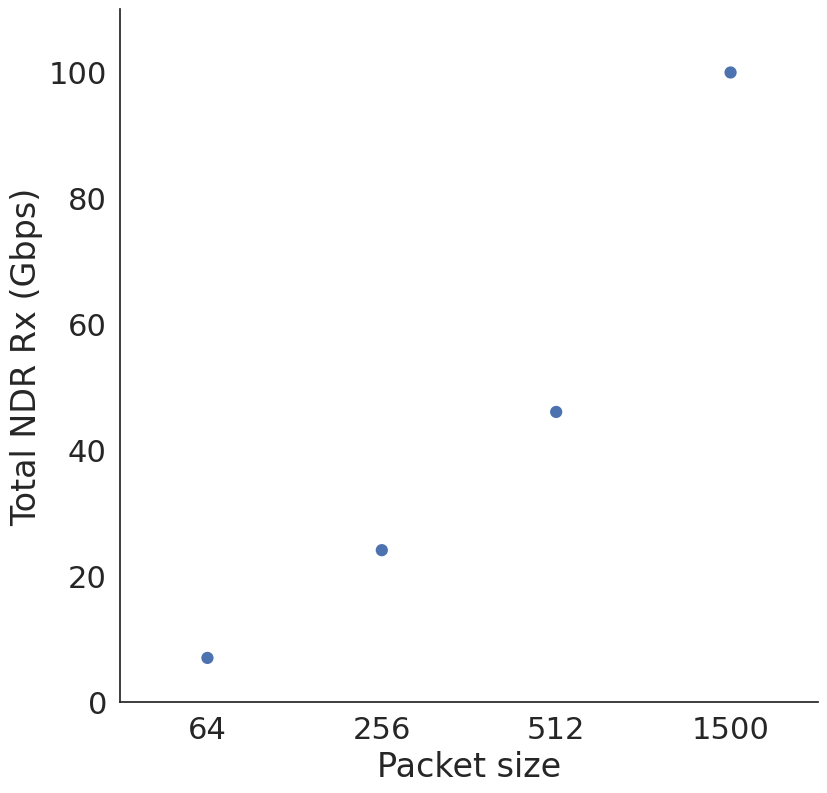

In [7]:
%matplotlib inline
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(9,9))

FREQ=2200

fig = sns.pointplot(
    data = bypass_df,
    x = 'packet_size',
    y = bypass_df['total_rx_L1']/(10**9),
    units = 'units',
    ax = ax1,
    #palette = 'colorblind',
    ci = 'sd',
    err_style = 'bars',
    markersize=1,
    errorwidth=3,
    join = False,
    linestyles = '--',
    linewidth = 0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax1.set(
    ylabel = 'Total NDR Rx (Gbps)',
    xlabel = 'Packet size',
    ylim = [0, 110],
    #title = f'CPU freq = {FREQ} Mhz, Packet size = {PKT_SIZE} B',
)
plt.setp(fig.lines,linewidth=1.25)

sns.despine()

# fig.get_figure().savefig("../output_figures/freq_total_packetloss_pkt_size64.pdf")

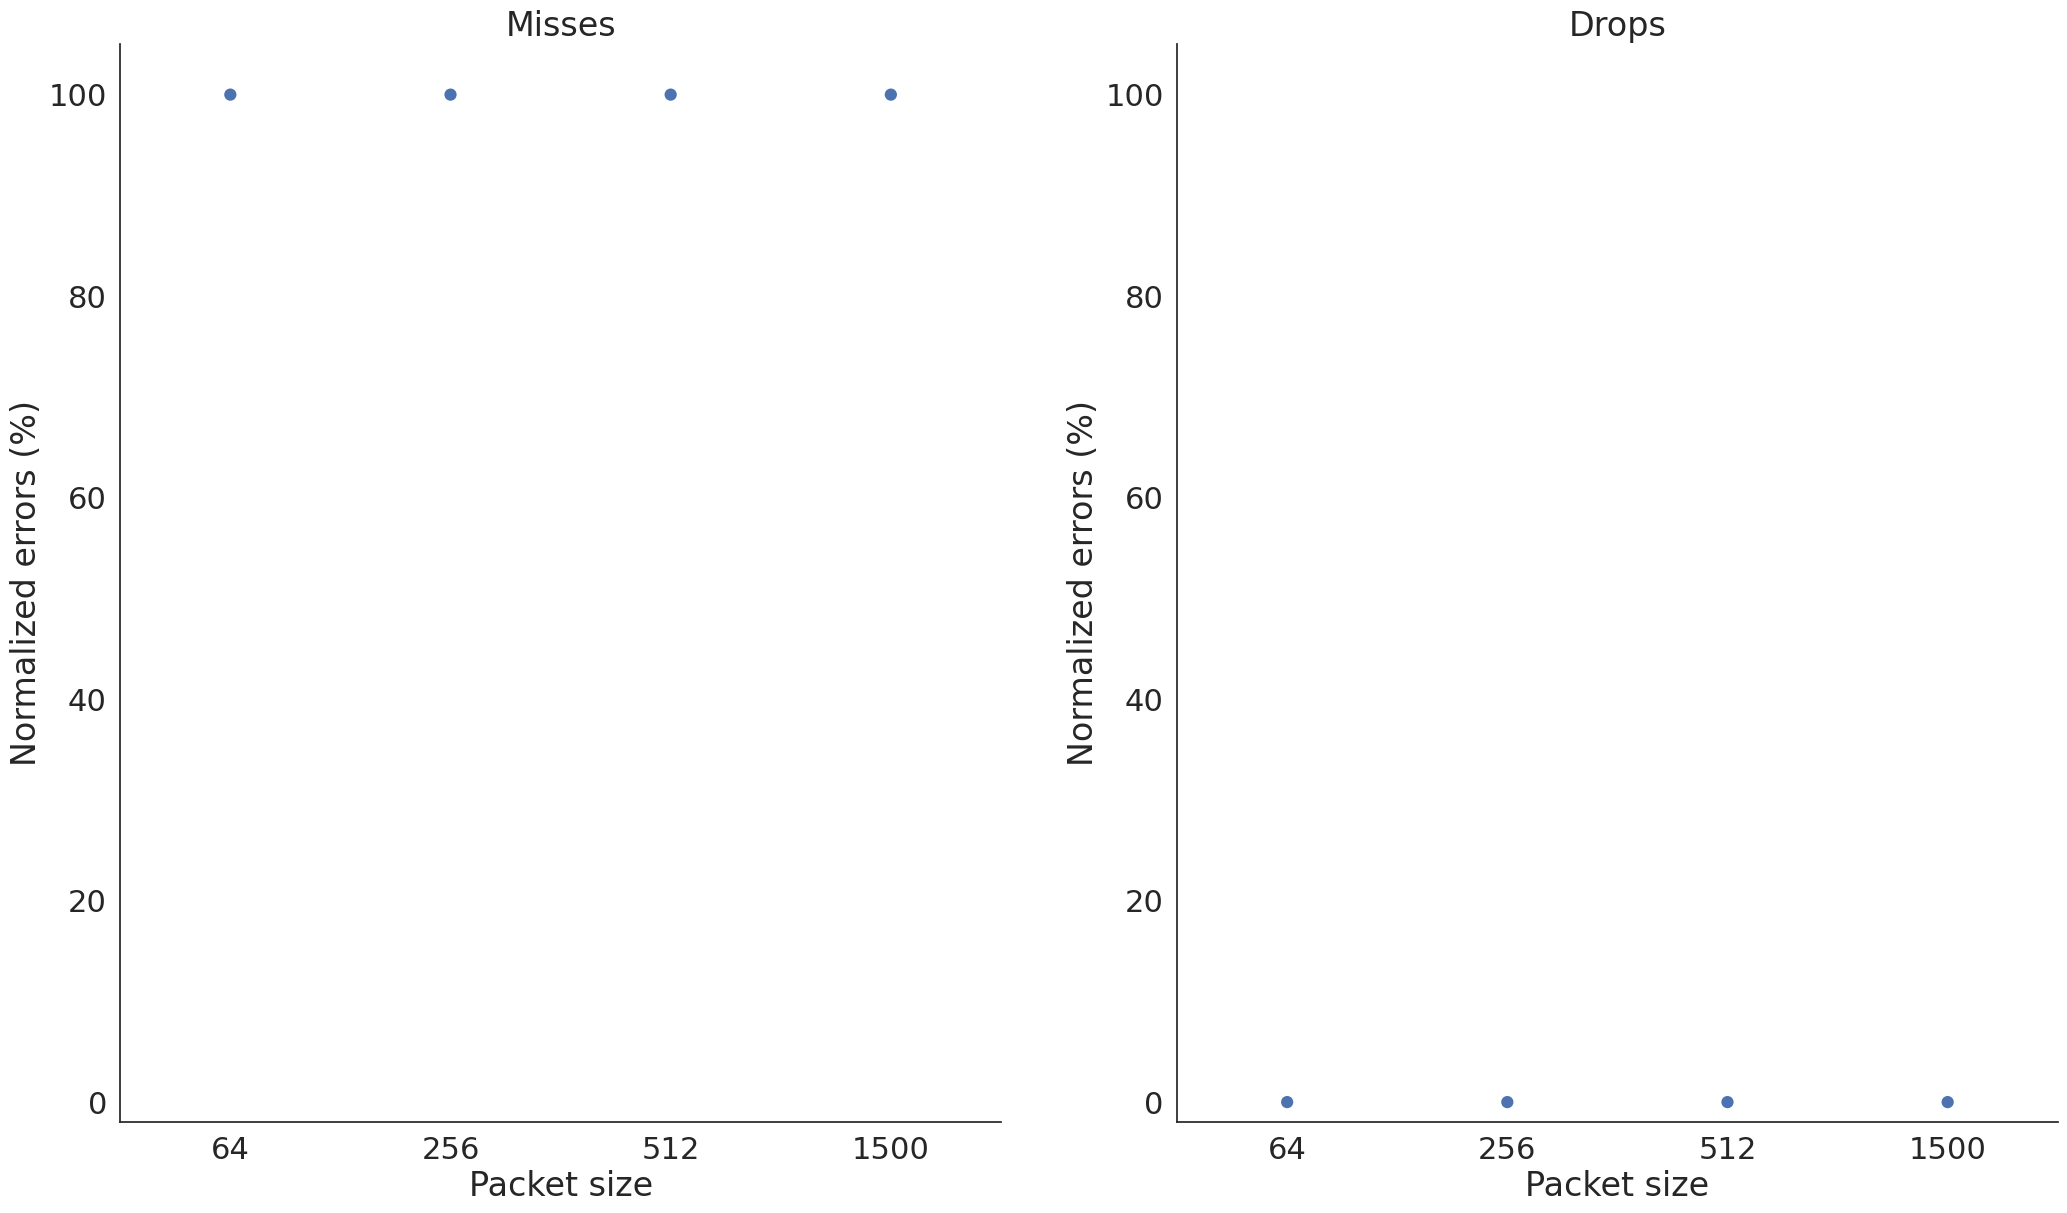

In [8]:
%matplotlib inline
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(25, 14))

fig = sns.pointplot(
    data = bypass_df,
    x = 'packet_size',
    y = bypass_df['misses']/bypass_df['total_errors']*100,
    units = 'units',
    ax = ax1,
    #palette = 'colorblind',
    ci = 'sd',
    err_style = 'bars',
    markersize=1,
    errorwidth=3,
    join = False,
    linestyles = '--',
    linewidth = 0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax1.set(
    ylabel = 'Normalized errors (%)',
    xlabel = 'Packet size',
    title = f'Misses',
    ylim = [-2, 105],
)
plt.setp(fig.lines,linewidth=1.25)

fig = sns.pointplot(
    data = bypass_df,
    x = 'packet_size',
    y = bypass_df['drops']/bypass_df['total_errors']*100,
    units = 'units',
    ax = ax2,
    #palette = 'colorblind',
    ci = 'sd',
    err_style = 'bars',
    markersize=1,
    errorwidth=3,
    join = False,
    linestyles = '--',
    linewidth = 0.005,
    # hue_order = [64, 256, 512, 1500],
)
ax2.set(
    ylabel = 'Normalized errors (%)',
    xlabel = 'Packet size',
    title = f'Drops',
    ylim = [-2, 105],
)
plt.setp(fig.lines,linewidth=1.25)

sns.despine()
